# Building RAG-based LLM Applications for Production

- **Blog post**: https://www.anyscale.com/blog/a-comprehensive-guide-for-building-rag-based-llm-applications-part-1
- **GitHub repository**: https://github.com/ray-project/llm-applications
- **Anyscale Endpoints**: https://endpoints.anyscale.com/ (serve + fine-tune LLMs)
- **Ray documentation**: https://docs.ray.io/

In this guide, we will learn how to:

- 💻 Develop a retrieval augmented generation (RAG) based LLM application from scratch.
- 🚀 Scale the major workloads (load, chunk, embed, index, serve, etc.) across multiple workers with different compute resources.
- ✅ Evaluate different configurations of our application to optimize for both per-component (ex. retrieval_score) and overall performance (quality_score).
- 🔀 Implement a hybrid agent routing approach b/w OSS and closed LLMs to create the most performant and cost effective application.
- 📦 Serve the application in a highly scalable and available manner.
- 💡 Learn how methods like fine-tuning, prompt engineering, lexical search, reranking, data flywheel, etc. impact our application's performance.

# Overview

Large language models (LLMs) have undoubtedly changed the way we interact with information. However, they come with their fair share of limitations as to what we can ask of them. Base LLMs (ex. Llama-2-70b, gpt-4, etc.) are only aware of the information that they've been trained on and will fall short when we require them to know information beyond that. Retrieval augmented generation (RAG) based LLM applications address this exact issue and extend the utility of LLMs and their generative reasoning abilities to our unique datasets. 

In this guide, we're going to build a RAG-based LLM application where we will incorporate external data sources to augment our LLM’s capabilities. Specifically, we will be building an assistant that can answer questions about [Ray](https://github.com/ray-project/ray) — a Python framework for productionizing and scaling ML workloads. The goal here is to make it easier for developers to adopt Ray, but also, as we'll see in this guide, to help improve our Ray documentation itself and provide a foundation for other LLM applications. We’ll also share challenges we faced along the way and how we overcame them.

**Note**: We have generalized this entire guide so that it can easily be extended to build RAG-based LLM applications on top of your own data.

<img width="500" src="https://images.ctfassets.net/xjan103pcp94/4PX0l1ruKqfH17YvUiMFPw/c60a7a665125cb8056bebcc146c23b76/image8.png">

Besides just building our LLM application, we’re also going to be focused on scaling and serving it in production. Unlike traditional machine learning, or even supervised deep learning, scale is a bottleneck for LLM applications from the very beginning. Large datasets, models, compute intensive workloads, serving requirements, etc. We’ll develop our application to be able to handle any scale as the world around us continues to grow. We’re also going to be focused on evaluation and performance. Our application involves many moving pieces: embedding models, chunking logic, the LLM itself, etc. and so it's important that we experiment with different configurations to optimize for the best quality responses. However, it's non-trivial to evaluate and quantitatively compare different configurations for a generative task. We’re going to break down evaluation of individual parts of our application (retrieval given query, generation given source), also assess the overall performance (end-to-end generation) and share findings towards an optimized configuration.

**Note**: We'll be experimenting with different LLMs (OpenAI, Llama, etc.) in this guide. You will need [OpenAI credentials](https://platform.openai.com/account/api-keys) to access [ChatGPT models](https://platform.openai.com/docs/models/) and [Anyscale Endpoints](https://endpoints.anyscale.com/) (hosted/private endpoints available) to serve + fine-tune OSS LLMs.

# Set up

We're going to start by setting up our base imports, directories and initializing Ray with credentials. We'll be using [Ray](https://docs.ray.io/) to easily scale our workloads with minimal changes to our code.

In [ ]:
import os
import ray

In [ ]:
import sys; sys.path.append("..")
import warnings; warnings.filterwarnings("ignore")
from dotenv import load_dotenv; load_dotenv()
%load_ext autoreload
%autoreload 2

In [ ]:
from rag.config import ROOT_DIR

In [ ]:
# Credentials
ray.init(runtime_env={
    "env_vars": {
        "OPENAI_API_BASE": os.environ["OPENAI_API_BASE"],
        "OPENAI_API_KEY": os.environ["OPENAI_API_KEY"], 
        "ANYSCALE_API_BASE": os.environ["ANYSCALE_API_BASE"],
        "ANYSCALE_API_KEY": os.environ["ANYSCALE_API_KEY"],
        "DB_CONNECTION_STRING": os.environ["DB_CONNECTION_STRING"],
    },
    "working_dir": str(ROOT_DIR)
})

2023-12-16 09:58:56,942	INFO worker.py:1458 -- Connecting to existing Ray cluster at address: 10.0.12.127:6379...
2023-12-16 09:58:56,981	INFO worker.py:1633 -- Connected to Ray cluster. View the dashboard at https://session-5ljni527x7edt2q6px7nuaejct.i.anyscaleuserdata-staging.com 
2023-12-16 09:58:57,086	INFO packaging.py:518 -- Creating a file package for local directory '/home/ray/ray-assistant/notebooks/..'.
2023-12-16 09:58:57,245	INFO packaging.py:346 -- Pushing file package 'gcs://_ray_pkg_491e42b54ab0d9cf.zip' (39.45MiB) to Ray cluster...
2023-12-16 09:58:57,371	INFO packaging.py:359 -- Successfully pushed file package 'gcs://_ray_pkg_491e42b54ab0d9cf.zip'.


Python version:,3.10.8
Ray version:,2.7.0
Dashboard:,http://session-5ljni527x7edt2q6px7nuaejct.i.anyscaleuserdata-staging.com


In [ ]:
ray.cluster_resources()

{'memory': 34359738368.0,
 'node:__internal_head__': 1.0,
 'object_store_memory': 9587318784.0,
 'accelerator_type:A10G': 1.0,
 'CPU': 8.0,
 'GPU': 1.0,
 'node:10.0.12.127': 1.0}

We've also created some mappings for the different embedding and language models we'll be developing with in our application:

In [ ]:
from rag.config import EMBEDDING_DIMENSIONS, MAX_CONTEXT_LENGTHS

In [ ]:
# Embedding dimensions
EMBEDDING_DIMENSIONS

{'thenlper/gte-base': 768,
 'thenlper/gte-large': 1024,
 'BAAI/bge-large-en': 1024,
 'text-embedding-ada-002': 1536,
 'gte-large-fine-tuned': 1024}

In [ ]:
# LLM context lengths (1 token = 3/4 word)
MAX_CONTEXT_LENGTHS

{'gpt-4': 8192,
 'gpt-3.5-turbo': 4096,
 'gpt-3.5-turbo-16k': 16384,
 'gpt-4-1106-preview': 128000,
 'meta-llama/Llama-2-7b-chat-hf': 4096,
 'meta-llama/Llama-2-13b-chat-hf': 4096,
 'meta-llama/Llama-2-70b-chat-hf': 4096,
 'codellama/CodeLlama-34b-Instruct-hf': 16384,
 'mistralai/Mistral-7B-Instruct-v0.1': 65536,
 'mistralai/Mixtral-8x7B-Instruct-v0.1': 32768}

# Data

Before we can start building our RAG application, we need to first create our vector DB that will contain our processed data sources.

<img width="1000" src="https://images.ctfassets.net/xjan103pcp94/3q5HUANQ4kS0V23cgEP0JF/ef3b62c5bc5c5c11b734fd3b73f6ea28/image3.png">

## Load data

In [ ]:
from pathlib import Path
from rag.config import EFS_DIR

We need to first download the [Ray documentation](https://docs.ray.io/) to a directory:
```bash
export EFS_DIR=/desired/output/directory
wget -e robots=off --recursive --no-clobber --page-requisites \
  --html-extension --convert-links --restrict-file-names=windows \
  --domains docs.ray.io --no-parent --accept=html \
  -P $EFS_DIR https://docs.ray.io/en/master/
```

We’re going to then load our docs contents into a [Ray Dataset](https://docs.ray.io/en/latest/data/data.html) so that we can perform operations at scale on them (ex. embed, index, etc.). With large data sources, models and application serving needs, scale is a day-1 priority for LLM applications. We want to build our applications in such a way that they can scale as our needs grow without us having to change our code later.

In [ ]:
# Ray dataset
DOCS_DIR = Path(EFS_DIR, "docs.ray.io/en/master/")
ds = ray.data.from_items([{"path": path} for path in DOCS_DIR.rglob("*.html") if not path.is_dir()])
print(f"{ds.count()} documents")

3282 documents


## Sections

Now that we have a dataset of all the paths to the html files, we're going to develop some functions that can appropriately extract the content from these files. We want to do this in a generalized manner so that we can perform this extraction across all of our docs pages (and so you can use it for your own data sources). Our process is to first identify the sections in our html page and then extract the text in between them. We save all of this into a list of dictionaries that map the text within a section to a specific url with a section anchor id.

<img width="800" src="https://images.ctfassets.net/xjan103pcp94/1eFnKmG5xqPIFtPupZ327X/f6152723e18322b90aaa8be5d2d5a6e4/image5.png">

In [ ]:
import matplotlib.pyplot as plt
from rag.data import extract_sections

In [ ]:
sample_html_fp = Path(EFS_DIR, "docs.ray.io/en/master/rllib/rllib-env.html")
extract_sections({"path": sample_html_fp})[0]

{'source': 'https://docs.ray.io/en/master/rllib/rllib-env.html#environments',
 'text': '\nEnvironments#\nRLlib works with several different types of environments, including Farama-Foundation Gymnasium, user-defined, multi-agent, and also batched environments.\nTip\nNot all environments work with all algorithms. Check out the algorithm overview for more information.\n'}

We can apply this extraction process (extract_section) in parallel to all the file paths in our dataset with just one line using Ray Data's [flat_map](https://docs.ray.io/en/latest/data/api/doc/ray.data.Dataset.flat_map.html):

In [ ]:
# Extract sections
sections_ds = ds.flat_map(extract_sections)
sections_ds.count()

2023-12-16 09:59:01,990	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[FlatMap(extract_sections)]
2023-12-16 09:59:01,990	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-12-16 09:59:01,991	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

5727

In [ ]:
section_lengths = []
for section in sections_ds.take_all():
    section_lengths.append(len(section["text"]))

## Chunk data

We now have a list of sections (with text and source of each section) but we shouldn't directly use this as context to our RAG application just yet. The text lengths of each section are all varied and many are quite large chunks. 

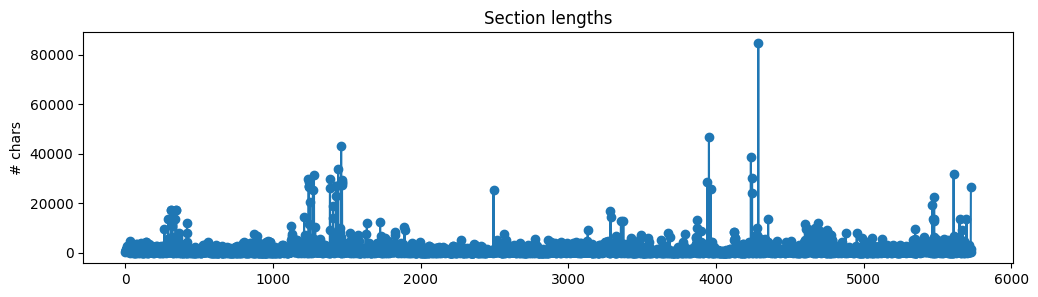

In [ ]:
# Plot
plt.figure(figsize=(12, 3))
plt.plot(section_lengths, marker='o')
plt.title("Section lengths")
plt.ylabel("# chars")
plt.show()

If we were to use these large sections, then we'd be inserting a lot of noisy/unwanted context and because all LLMs have a maximum context length, we wouldn't be able to fit too much other relevant context. So instead, we're going to split the text within each section into smaller chunks. Intuitively, smaller chunks will encapsulate single/few concepts and will be less noisy compared to larger chunks. We're going to choose some typical text splitting values (ex. chunk_size=300) to create our chunks for now but we'll be experimenting with a wider range of values later.

In [ ]:
from functools import partial
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [ ]:
# Text splitter
chunk_size = 300
chunk_overlap = 50
text_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", " ", ""],
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap,
    length_function=len)

In [ ]:
# Chunk a sample section
sample_section = sections_ds.take(1)[0]
chunks = text_splitter.create_documents(
    texts=[sample_section["text"]], 
    metadatas=[{"source": sample_section["source"]}])
print (chunks[0])

2023-12-16 09:59:27,544	INFO dataset.py:2380 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.
2023-12-16 09:59:27,547	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[FlatMap(extract_sections->Limit[1])] -> LimitOperator[limit=1]
2023-12-16 09:59:27,548	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-12-16 09:59:27,548	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

page_content='Ray Dashboard#\nRay provides a web-based dashboard for monitoring and debugging Ray applications.\nThe visual representation of the system state, allows users to track the performance\nof applications and troubleshoot issues.' metadata={'source': 'https://docs.ray.io/en/master/ray-observability/getting-started.html#ray-dashboard'}


While chunking our dataset is relatively fast, let’s wrap the chunking logic into a function so that we can apply the workload at scale so that chunking remains just as fast as our data sources grow:


In [ ]:
def chunk_section(section, chunk_size, chunk_overlap):
    text_splitter = RecursiveCharacterTextSplitter(
        separators=["\n\n", "\n", " ", ""],
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len)
    chunks = text_splitter.create_documents(
        texts=[section["text"]], 
        metadatas=[{"source": section["source"]}])
    return [{"text": chunk.page_content, "source": chunk.metadata["source"]} for chunk in chunks]

In [ ]:
# Scale chunking
chunks_ds = sections_ds.flat_map(partial(
    chunk_section, 
    chunk_size=chunk_size, 
    chunk_overlap=chunk_overlap))
print(f"{chunks_ds.count()} chunks")
chunks_ds.show(1)

2023-12-16 09:59:27,844	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[FlatMap(extract_sections)->FlatMap(partial)]
2023-12-16 09:59:27,845	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-12-16 09:59:27,846	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

2023-12-16 09:59:49,946	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[FlatMap(extract_sections)->FlatMap(partial->Limit[1])] -> LimitOperator[limit=1]
2023-12-16 09:59:49,947	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-12-16 09:59:49,948	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


32276 chunks


Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

{'text': 'Reference#\nMonitor and debug your Ray applications and clusters using the API and CLI documented in these references.\nThe guides include:\nState API\nState CLI\nSystem Metrics', 'source': 'https://docs.ray.io/en/master/ray-observability/reference/index.html#reference'}


## Embed data

Now that we've created small chunks from our sections, we need a way to identify the most relevant ones for a given query. A very effective and quick method is to embed our data using a pretrained model and use the same model to embed the query. We can then compute the distance between all of the chunk embeddings and our query embedding to determine the top-k chunks. There are many different pretrained models to choose from to embed our data but the most popular ones can be discovered through [HuggingFace's Massive Text Embedding Benchmark (MTEB)](https://huggingface.co/spaces/mteb/leaderboard) leaderboard. These models were pretrained on very large text corpus through tasks such as next/masked token prediction which allowed them to learn to represent subtokens in N dimensions and capture semantic relationships. We can leverage this to represent our data and identify the most relevant contexts to use to answer a given query. We're using Langchain's Embedding wrappers ([HuggingFaceEmbeddings](https://api.python.langchain.com/en/latest/embeddings/langchain.embeddings.huggingface.HuggingFaceEmbeddings.html) and [OpenAIEmbeddings](https://api.python.langchain.com/en/latest/embeddings/langchain.embeddings.openai.OpenAIEmbeddings.html)) to easily load the models and embed our document chunks.

**Note**: embeddings aren't the only way to determine the more relevant chunks. We could also use an LLM to decide! However, because LLMs are much larger than these embedding models and have maximum context lengths, it's better to use embeddings to retrieve the top k chunks. And then we could use LLMs on the fewer k chunks to determine the <k chunks to use as the context to answer our query. We could also use reranking (ex. [Cohere Rerank](https://txt.cohere.com/rerank/)) to further identify the most relevant chunks to use. We could also combine embeddings with traditional information retrieval methods such as keyword matching, which could be useful for matching for unique tokens that may potentially be lost when embedding subtokens.

In [ ]:
from langchain.embeddings import OpenAIEmbeddings
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
import numpy as np
from ray.data import ActorPoolStrategy

In [ ]:
def get_embedding_model(embedding_model_name, model_kwargs, encode_kwargs):
    if embedding_model_name == "text-embedding-ada-002":
        embedding_model = OpenAIEmbeddings(
            model=embedding_model_name,
            openai_api_base=os.environ["OPENAI_API_BASE"],
            openai_api_key=os.environ["OPENAI_API_KEY"])
    else:
        embedding_model = HuggingFaceEmbeddings(
            model_name=embedding_model_name,  # also works with model_path
            model_kwargs=model_kwargs,
            encode_kwargs=encode_kwargs)
    return embedding_model

In [ ]:
class EmbedChunks:
    def __init__(self, model_name):
        self.embedding_model = get_embedding_model(
            embedding_model_name=model_name,
            model_kwargs={"device": "cuda"},
            encode_kwargs={"device": "cuda", "batch_size": 100})
    def __call__(self, batch):
        embeddings = self.embedding_model.embed_documents(batch["text"])
        return {"text": batch["text"], "source": batch["source"], "embeddings": embeddings}

Here we're able to embed our chunks at scale by using [map_batches](https://docs.ray.io/en/latest/data/api/doc/ray.data.Dataset.map_batches.html). All we had to do was define the `batch_size` and the compute resources.

In [ ]:
# Embed chunks
embedding_model_name = "thenlper/gte-base"
embedded_chunks = chunks_ds.map_batches(
    EmbedChunks,
    fn_constructor_kwargs={"model_name": embedding_model_name},
    batch_size=100, 
    num_gpus=1,
    compute=ActorPoolStrategy(size=1))

In [ ]:
# Sample
sample = embedded_chunks.take(1)
print ("embedding size:", len(sample[0]["embeddings"]))
print (sample[0]["text"])

## Index data

Now that we have our embedded chunks, we need to index (store) them somewhere so that we can retrieve them quickly for inference. While there are many popular vector database options, we're going to use [Postgres with pgvector](https://github.com/pgvector/pgvector) for it's simplificty and performance. We'll create a table (`document`) and write the (`text`, `source`, `embedding`) triplets for each embedded chunk we have.

<img width="700" src="https://images.ctfassets.net/xjan103pcp94/3z1ryYkOtUjj6N1IuavJPf/ae60dc4a10c94e2cc928c38701befb51/image2.png">

In [ ]:
import psycopg
from pgvector.psycopg import register_vector
os.environ["MIGRATION_FP"] = f"../migrations/vector-{EMBEDDING_DIMENSIONS[embedding_model_name]}.sql"
os.environ["SQL_DUMP_FP"] = f"{EFS_DIR}/sql_dumps/{embedding_model_name.split('/')[-1]}_{chunk_size}_{chunk_overlap}.sql"

In [ ]:
%%bash
# Set up
psql "$DB_CONNECTION_STRING" -c "DROP TABLE IF EXISTS document;"
echo $MIGRATION_FP
sudo -u postgres psql -f $MIGRATION_FP
echo $SQL_DUMP_FP

NOTICE:  table "document" does not exist, skipping


DROP TABLE
../migrations/vector-768.sql
CREATE TABLE
/efs/shared_storage/goku/sql_dumps/gte-base_300_50.sql


**Note**: Run `bash setup-pgvector.sh` first!

In [ ]:
%%bash
# Drop table and load index
psql "$DB_CONNECTION_STRING" -c "DROP TABLE IF EXISTS document;"  # drop
sudo -u postgres psql -f $MIGRATION_FP  # create
psql "$DB_CONNECTION_STRING" -f $SQL_DUMP_FP  # load
psql "$DB_CONNECTION_STRING" -c "SELECT count(*) FROM document;"  # num rows

DROP TABLE
CREATE TABLE
SET
SET
SET
SET
SET
 set_config 
------------
 
(1 row)

SET
SET
SET
SET
ALTER TABLE
ALTER TABLE


psql:/efs/shared_storage/goku/sql_dumps/gte-base_300_50.sql:20: ERROR:  relation "public.data_document" does not exist
psql:/efs/shared_storage/goku/sql_dumps/gte-base_300_50.sql:22: ERROR:  relation "public.data_document" does not exist


DROP SEQUENCE
DROP TABLE


psql:/efs/shared_storage/goku/sql_dumps/gte-base_300_50.sql:25: ERROR:  sequence "data_document_id_seq" does not exist
psql:/efs/shared_storage/goku/sql_dumps/gte-base_300_50.sql:26: ERROR:  table "data_document" does not exist


DROP EXTENSION
CREATE EXTENSION
COMMENT
SET
SET
CREATE TABLE
ALTER TABLE
CREATE SEQUENCE
ALTER SEQUENCE
ALTER SEQUENCE
CREATE TABLE
ALTER TABLE
CREATE SEQUENCE
ALTER SEQUENCE
ALTER SEQUENCE
ALTER TABLE
ALTER TABLE
COPY 40433
COPY 32276
 setval 
--------
  40433
(1 row)

 setval 
--------
  32276
(1 row)

ALTER TABLE
ALTER TABLE
 count 
-------
 32276
(1 row)



If we don't have an index saved already, we can index the data and save it:

In [ ]:
class StoreResults:
    def __call__(self, batch):
        with psycopg.connect(os.environ["DB_CONNECTION_STRING"]) as conn:
            register_vector(conn)
            with conn.cursor() as cur:
                for text, source, embedding in zip(batch["text"], batch["source"], batch["embeddings"]):
                    cur.execute("INSERT INTO document (text, source, embedding) VALUES (%s, %s, %s)", (text, source, embedding,),)
        return {}

And once again, we can use Ray Data’s [map_batches](https://docs.ray.io/en/latest/data/api/doc/ray.data.Dataset.map_batches.html) to perform this indexing in parallel:

In [ ]:
# Index data
embedded_chunks.map_batches(
    StoreResults,
    batch_size=128,
    num_cpus=1,
    compute=ActorPoolStrategy(size=6),
).count()

2023-11-06 09:15:46,268	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[FlatMap(extract_sections)->FlatMap(partial)] -> ActorPoolMapOperator[MapBatches(EmbedChunks)] -> ActorPoolMapOperator[MapBatches(StoreResults)]
2023-11-06 09:15:46,269	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-11-06 09:15:46,270	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
2023-11-06 09:15:46,281	INFO actor_pool_map_operator.py:106 -- MapBatches(EmbedChunks): Waiting for 1 pool actors to start...
2023-11-06 09:15:50,926	INFO actor_pool_map_operator.py:106 -- MapBatches(StoreResults): Waiting for 6 pool actors to start...


Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

2023-11-06 09:17:47,493	WARNING actor_pool_map_operator.py:265 -- Your batch size is too large. Currently, your batch size is 128. Your dataset contains 0, and Ray Data tried to parallelize it across 6 actors. To parallelize this fully across all 6 actors, set batch size to not exceed `0 / 6 = 0`.


0

In [ ]:
%%bash
# Save index
rm -rf $SQL_DUMP_FP
mkdir -p $(dirname "$SQL_DUMP_FP") && touch $SQL_DUMP_FP
sudo -u postgres pg_dump -c > $SQL_DUMP_FP  # save

# Retrieval

With our embedded chunks indexed in our vector database, we're ready to perform retrieval for a given query. We'll start by using the same embedding model we used to embed our text chunks to now embed the incoming query.

<img width="1000" src="https://images.ctfassets.net/xjan103pcp94/1hKBrFU2lyR5LLebFyq2ZL/8845c36ff98eb47005338de6ab6dbf50/image14.png">

In [ ]:
import json
import numpy as np

In [ ]:
# Embed query
embedding_model = HuggingFaceEmbeddings(model_name=embedding_model_name)
query = "What is the default batch size for map_batches?"
embedding = np.array(embedding_model.embed_query(query))
len(embedding)

Then, we'll retrieve the top most revelant chunks by extracting the closest embedded chunks to our embedded query. We use cosine distance (`<=>`) but there are [many options](https://github.com/pgvector/pgvector#vector-operators) to choose from. Once we retrieve the top `num_chunks`, we can collect the text for each chunk and use it as context to generate a response.

In [ ]:
# Get context
num_chunks = 5
with psycopg.connect(os.environ["DB_CONNECTION_STRING"]) as conn:
    register_vector(conn)
    with conn.cursor() as cur:
        # cur.execute("SELECT * FROM document ORDER BY embedding <=> %s LIMIT %s", (embedding, num_chunks))
        cur.execute("SELECT *, (embedding <=> %s) AS similarity_score FROM document ORDER BY similarity_score LIMIT %s", (embedding, num_chunks))
        rows = cur.fetchall()
        ids = [row[0] for row in rows]
        context = [{"text": row[1]} for row in rows]
        sources = [row[2] for row in rows]
        scores = [row[4] for row in rows]

In [ ]:
for i, item in enumerate(context):
    print (ids[i])
    print (scores[i])
    print (sources[i])
    print (item["text"])
    print ()

14887
0.06207154583656549
https://docs.ray.io/en/master/data/api/doc/ray.data.Dataset.map_batches.html#ray-data-dataset-map-batches
entire blocks as batches (blocks may contain different numbers of rows).
The actual size of the batch provided to fn may be smaller than
batch_size if batch_size doesn’t evenly divide the block(s) sent
to a given map task. Default batch_size is 4096 with “default”.

15009
0.06654224236622186
https://docs.ray.io/en/master/data/transforming-data.html#configuring-batch-size
batch_size.
Note
The default batch size depends on your resource type. If you’re using CPUs,
the default batch size is 4096. If you’re using GPUs, you must specify an explicit
batch size.

15051
0.07562640027010847
https://docs.ray.io/en/master/data/batch_inference.html#configuring-batch-size
# Specify that each input batch should be of size 2.
ds.map_batches(assert_batch, batch_size=2)
Caution
The default batch_size of 4096 may be too large for datasets with large rows
(for example, table

Let's wrap this into a convenient function:

In [ ]:
def semantic_search(query, embedding_model, k):
    embedding = np.array(embedding_model.embed_query(query))
    with psycopg.connect(os.environ["DB_CONNECTION_STRING"]) as conn:
        register_vector(conn)
        with conn.cursor() as cur:
            cur.execute("SELECT * FROM document ORDER BY embedding <=> %s LIMIT %s", (embedding, k),)
            rows = cur.fetchall()
            semantic_context = [{"id": row[0], "text": row[1], "source": row[2]} for row in rows]
    return semantic_context

# Generation

We can now use the context to generate a response from our LLM. Without this relevant context that we retrieved, the LLM may not have been able to accurately answer our question. And as our data grows, we can just as easily embed and index any new data and be able to retrieve it to answer questions.

<img width="500" src="https://images.ctfassets.net/xjan103pcp94/38I8en8Tyf0cM4LUhjygoq/739d456c80841b4c28fe80f73ea5856b/image16.png">

In [ ]:
import openai
import time

In [ ]:
from rag.generate import prepare_response
from rag.utils import get_client

In [ ]:
def generate_response(
    llm, temperature=0.0, stream=True,
    system_content="", assistant_content="", user_content="", 
    max_retries=1, retry_interval=60):
    """Generate response from an LLM."""
    retry_count = 0
    client = get_client(llm=llm)
    messages = [{"role": role, "content": content} for role, content in [
        ("system", system_content), 
        ("assistant", assistant_content), 
        ("user", user_content)] if content]
    while retry_count <= max_retries:
        try:
            chat_completion = client.chat.completions.create(
                model=llm,
                temperature=temperature,
                stream=stream,
                messages=messages,
            )
            return prepare_response(chat_completion, stream=stream)

        except Exception as e:
            print(f"Exception: {e}")
            time.sleep(retry_interval)  # default is per-minute rate limits
            retry_count += 1
    return ""

**Note**: We’re using a temperature of 0.0 to enable reproducible experiments but you should adjust this based on your use case. For use cases that need to always be factually grounded, we recommend very low temperature values while more creative tasks can benefit from higher temperatures.

In [ ]:
# Generate response
query = "What is the default batch size for map_batches?"
response = generate_response(
    llm="meta-llama/Llama-2-70b-chat-hf",
    temperature=0.0,
    stream=True,
    system_content="Answer the query using the context provided. Be succinct.",
    user_content=f"query: {query} context: {context}")
# Stream response
for content in response:
    print(content, end='', flush=True)

  The default batch size for map_batches is 4096.

## Agent

Let's combine the context retrieval and response generation together into a convenient query agent that we can use to easily generate our responses. This will take care of setting up our agent (embedding and LLM model), as well as the context retrieval, and pass it to our LLM for response generation.

In [ ]:
from rag.embed import get_embedding_model
from rag.utils import get_num_tokens, trim

In [ ]:
class QueryAgent:
    def __init__(self, embedding_model_name="thenlper/gte-base",
                 llm="meta-llama/Llama-2-70b-chat-hf", temperature=0.0, 
                 max_context_length=4096, system_content="", assistant_content=""):
        
        # Embedding model
        self.embedding_model = get_embedding_model(
            embedding_model_name=embedding_model_name, 
            model_kwargs={"device": "cuda"}, 
            encode_kwargs={"device": "cuda", "batch_size": 100})
        
        # Context length (restrict input length to 50% of total context length)
        max_context_length = int(0.5*max_context_length)
        
        # LLM
        self.llm = llm
        self.temperature = temperature
        self.context_length = max_context_length - get_num_tokens(system_content + assistant_content)
        self.system_content = system_content
        self.assistant_content = assistant_content

    def __call__(self, query, num_chunks=5, stream=True):
        # Get sources and context
        context_results = semantic_search(
            query=query, 
            embedding_model=self.embedding_model, 
            k=num_chunks)
            
        # Generate response
        context = [item["text"] for item in context_results]
        sources = [item["source"] for item in context_results]
        user_content = f"query: {query}, context: {context}"
        answer = generate_response(
            llm=self.llm,
            temperature=self.temperature,
            stream=stream,
            system_content=self.system_content,
            assistant_content=self.assistant_content,
            user_content=trim(user_content, self.context_length))

        # Result
        result = {
            "question": query,
            "sources": sources,
            "answer": answer,
            "llm": self.llm,
        }
        return result

With this, we can use our RAG application in just a few lines:

In [ ]:
embedding_model_name = "thenlper/gte-base"
llm = "meta-llama/Llama-2-7b-chat-hf"

In [ ]:
query = "What is the default batch size for map_batches?"
system_content = "Answer the query using the context provided. Be succinct."
agent = QueryAgent(
    embedding_model_name=embedding_model_name,
    llm=llm,
    max_context_length=MAX_CONTEXT_LENGTHS[llm],
    system_content=system_content)
result = agent(query=query, stream=False)
print("\n\n", json.dumps(result, indent=2))



 {
  "question": "What is the default batch size for map_batches?",
  "sources": [
    "https://docs.ray.io/en/master/data/api/doc/ray.data.Dataset.map_batches.html#ray-data-dataset-map-batches",
    "https://docs.ray.io/en/master/data/transforming-data.html#configuring-batch-size",
    "https://docs.ray.io/en/master/data/batch_inference.html#configuring-batch-size",
    "https://docs.ray.io/en/master/data/batch_inference.html#configuring-batch-size",
    "https://docs.ray.io/en/master/tune/getting-started.html#setting-up-a-tuner-for-a-training-run-with-tune"
  ],
  "answer": "  The default batch size for `map_batches` is 4096. However, this can vary depending on the resource type, with a default of 4096 for CPUs and a specific batch size required for GPUs. It's important to note that the default batch size may be too large for datasets with large rows, and configuring the batch size can help improve performance.",
  "llm": "meta-llama/Llama-2-7b-chat-hf"
}


# Evaluation

So far, we've chosen typical/arbitrary values for the various parts of our RAG application. But if we were to change something, such as our chunking logic, embedding model, LLM, etc. how can we know that we have a better configuration than before? A generative task like this is very difficult to quantitatively assess and so we need to develop reliable ways to do so.

Because we have many moving parts in our application, we need to perform both unit/component and end-to-end evaluation. Component-wise evaluation can involve evaluating our retrieval in isolation (is the best source in our set of retrieved chunks) and evaluating our LLMs response (given the best source, is the LLM able to produce a quality answer). And for end-to-end evaluation, we can assess the quality of the entire system (given the data sources, what is the quality of the response).
We'll be asking our evaluator LLM to score the quality of the response between 1-5 using the context, however, we could also have it produce scores for other dimensions such as hallucination (is the generated answer using information only from the provided context), toxicity, etc.

**Note**: We could have constrained the score to be binary (0/1), which might be more interpretable (ex. the response was either correct or incorrect). However, we introduced a higher variance in our scores to develop a deeper, fine-grained, understanding of how LLMs score responses (ex. LLM bias towards responses).



<img width="1000" src="https://images.ctfassets.net/xjan103pcp94/17UQdsEImsXOOdDlT06bvi/4a9b9e46e157541a1178b6938624176a/llm_evaluations.png">

In [ ]:
# If running tests / small samples, set num_samples to <10
EXPERIMENTS_DIR = Path(ROOT_DIR, "experiments")
NUM_SAMPLES = None  # None = all samples

## Evaluator

We're going to start by determining our evaluator. Given a response to a query and relevant context, our evaluator should be a trusted way to score/assess the quality of the response. But before we can determine our evaluator, we need a dataset of questions and the source where the answer comes from. We can use this dataset to ask our different evaluators to provide an answer and then rate their answer (ex. score between 1-5). We can then inspect this dataset to determine if our evaluator is unbiased and has sound reasoning for the scores that are assigned.

**Note**: We’re evaluating the ability of our LLM to generate a response given the relevant context. This is a component-level evaluation (`quality_score (LLM)`) because we aren’t using retrieval to fetch the relevant context.

We'll start by manually creating our dataset (keep reading if you can’t manually create a dataset). We have a list of user queries and the ideal source to answer the query [datasets/eval-dataset-v1.jsonl](https://github.com/ray-project/llm-applications/blob/main/datasets/eval-dataset-v1.jsonl). We will our LLM app above to generate reference answer for each query/source pair using `gpt-4`.

In [ ]:
from bs4 import BeautifulSoup
from IPython.display import JSON, clear_output, display
from tqdm import tqdm
import urllib.parse

In [ ]:
from rag.evaluate import extract_from_response
from rag.data import fetch_text

In [ ]:
# Load dataset
with open(Path(ROOT_DIR, "datasets/eval-dataset-v1.jsonl"), "r") as f:
    data = [json.loads(item) for item in list(f)]

In [ ]:
data[:5]

[{'question': 'I’m struggling a bit with Ray Data type conversions when I do map_batches. Any advice?',
  'source': 'https://docs.ray.io/en/master/data/transforming-data.html#configuring-batch-format'},
 {'question': 'How does autoscaling work in a Ray Serve application?',
  'source': 'https://docs.ray.io/en/master/serve/scaling-and-resource-allocation.html#autoscaling'},
 {'question': 'how do I get the address of a ray node',
  'source': 'https://docs.ray.io/en/master/ray-core/miscellaneous.html#node-information'},
 {'question': 'Does Ray support NCCL?',
  'source': 'https://docs.ray.io/en/master/ray-more-libs/ray-collective.html'},
 {'question': 'Is Ray integrated with DeepSpeed?',
  'source': 'https://docs.ray.io/en/master/ray-air/examples/gptj_deepspeed_fine_tuning.html#fine-tuning-the-model-with-ray-air-a-name-train-a'}]

In [ ]:
# Sample
uri = "https://docs.ray.io/en/master/data/transforming-data.html#configuring-batch-format"
fetch_text(uri=uri)

'\nConfiguring batch format#\nRay Data represents batches as dicts of NumPy ndarrays or pandas DataFrames. By\ndefault, Ray Data represents batches as dicts of NumPy ndarrays.\nTo configure the batch type, specify batch_format in\nmap_batches(). You can return either format from your function.\n\n\n\nNumPy\nfrom typing import Dict\nimport numpy as np\nimport ray\n\ndef increase_brightness(batch: Dict[str, np.ndarray]) -> Dict[str, np.ndarray]:\n    batch["image"] = np.clip(batch["image"] + 4, 0, 255)\n    return batch\n\nds = (\n    ray.data.read_images("s3://anonymous@ray-example-data/image-datasets/simple")\n    .map_batches(increase_brightness, batch_format="numpy")\n)\n\n\n\n\n\npandas\nimport pandas as pd\nimport ray\n\ndef drop_nas(batch: pd.DataFrame) -> pd.DataFrame:\n    return batch.dropna()\n\nds = (\n    ray.data.read_csv("s3://anonymous@air-example-data/iris.csv")\n    .map_batches(drop_nas, batch_format="pandas")\n)\n\n\n\n\n'

In [ ]:
# Content for inference
system_content = """
    Answer the query using the context provided. Be succinct.
    Then, you must {score} your response between 1 and 5.
    You must return your response in a line with only the score.
    Do not add any more details.
    On a separate line provide your {reasoning} for the score as well.
    Return your response following the exact format outlined below.
    Do not add or remove anything.
    And all of this must be in a valid JSON format.
    
    {"answer": answer,
     "score": score,
     "reasoning": reasoning}
    """
assistant_content = ""

We can extract the text from this context and pass it to our LLM to generate a response to the question. We’re also going to ask it to score the quality of its response for the query. To do this, we’ve defined a `QueryAgentWithContext` that inherits from `QueryAgent`, with the change that we’re providing the context and it doesn’t need to retrieve it.

In [ ]:
class QueryAgentWithContext(QueryAgent):
    def __call__(self, query, context):
        user_content = f"query: {query}, context: {context}"
        response = generate_response(
            llm=self.llm,
            temperature=self.temperature,
            stream=False,
            system_content=self.system_content,
            assistant_content=self.assistant_content,
            user_content=user_content[: self.context_length])
        return response

In [ ]:
def get_references(data, llm, temperature, system_content, assistant_content, num_samples=None):
    # Initialize agent
    agent = QueryAgentWithContext(
        llm=llm, 
        temperature=temperature,
        system_content=system_content,
        assistant_content=assistant_content)
    
    results = []
    for row in tqdm(data[:num_samples]):
        # Generate response
        query = row["question"]
        context = fetch_text(uri=row["source"])
        response = agent(query=query, context=context)

        # Extract from response
        answer, score, reasoning = extract_from_response(response=response)
        result = ({
                "question": query,
                "source": row["source"],
                "answer": answer,
                "score": score,
                "reasoning": reasoning,
            })
        results.append(result)
        clear_output(wait=True)
        display(JSON(json.dumps(result, indent=2)))
    return results

In [ ]:
# Refernces
REFERENCES_FILE_PATH = Path(EXPERIMENTS_DIR, "references", "gpt-4.json")
REFERENCES_FILE_PATH.parent.mkdir(parents=True, exist_ok=True)

In [ ]:
# gpt-4
results = get_references(
    data=data, num_samples=NUM_SAMPLES, llm="gpt-4", temperature=0.0, 
    system_content=system_content, assistant_content=assistant_content)
print (np.mean([float(result["score"]) for result in results if result["score"]]))

<IPython.core.display.JSON object>

100%|██████████| 1/1 [00:12<00:00, 12.55s/it]

5.0


In [ ]:
# Save to file
with open(REFERENCES_FILE_PATH, "w") as fp:
    json.dump(results, fp, indent=4)

We can now create a dataset with query, source, response, score and reasoning. We can inspect this to determine if our evaluator is of high quality. We found that `gpt-4` was a high quality evaluator based on the scores and reasonings it provided. We performed the same evaluation with other LLMs (ex. `Llama-2-70b`) and we found that they lacked the appropriate reasoning and were very generous with responses from themselves.

**Note**: A more thorough evaluation would also test for the following by asking the evaluator to compare responses from different LLMs across the following:
- position (which responses we show first) 
- verbosity (longer responses are favored) 
- nepotism (ex. GPT4 prefers GPT 3.5, etc.)


In [ ]:
EVALUATOR = "gpt-4"

## Cold start

We may not always have a prepared dataset of questions and the best source to answer that question readily available. To address this cold start problem, we could use an LLM to look at our text chunks and generate questions that the specific chunk would answer. This provides us with quality questions and the exact source the answer is in. However, this dataset generation method could be a bit noisy. The generated questions may not always have high alignment to what our users may ask. And the specific chunk we say is the best source may also have that exact information in other chunks. Nonetheless, this is a great way to start our development process while we collect + manually label a high quality dataset.

<img width="800" src="https://images.ctfassets.net/xjan103pcp94/3QR9zkjtpgeqK8XKPteTav/76aa9e7743330e7fcf73b07332a7ddf2/image10.png">

In [ ]:
# Prompt
num_questions = 3
system_content = f"""
Create {num_questions} questions using only the context provided.
End each question with a '?' character and then in a newline write the answer to that question using only the context provided.
Separate each question/answer pair by a newline.
"""

In [ ]:
# Generate questions
synthetic_data = []
for chunk in chunks[:1]:  # small samples
    response = generate_response(
        llm="gpt-4",
        temperature=0.0,
        stream=False,
        system_content=system_content,
        user_content=f"context: {chunk.page_content}")
    entries = response.split("\n\n")
    for entry in entries:
        question, answer = entry.split("\n")
        synthetic_data.append({"question": question, "source": chunk.metadata["source"], "answer": answer})

In [ ]:
synthetic_data[:3]

[{'question': 'What is the Ray Dashboard used for?',
  'source': 'https://docs.ray.io/en/master/ray-observability/getting-started.html#ray-dashboard',
  'answer': 'The Ray Dashboard is used for monitoring and debugging Ray applications.'},
 {'question': 'What does the visual representation of the Ray Dashboard allow users to do?',
  'source': 'https://docs.ray.io/en/master/ray-observability/getting-started.html#ray-dashboard',
  'answer': 'The visual representation of the Ray Dashboard allows users to track the performance of applications and troubleshoot issues.'},
 {'question': 'Is the Ray Dashboard web-based?',
  'source': 'https://docs.ray.io/en/master/ray-observability/getting-started.html#ray-dashboard',
  'answer': 'Yes, the Ray Dashboard is web-based.'}]

## Experiments

With our evaluator set, we're ready to start experimenting with the various components in our LLM application. While we could perform this as a large [hyperparameter tuning experiment](https://docs.ray.io/en/latest/tune/index.html), where we can search across promising combinations of values/decisions, we're going to evaluate one decision at a time and set the best value for the next experiment.

**Note**: this approach is slightly imperfect because many of our decisions are not indepedent (ex. `chunk_size` and `num_chunks` should ideally be evaluated across many combinations of values).

<img width="700" src="https://images.ctfassets.net/xjan103pcp94/2LlTUhNFzfLM775IVSxjkX/af49d7b4e0fdd4a482d29cf6eab5067f/image13.png">

### Utilities

Before we start our experiments, we’re going to define a few more utility functions. Our evaluation workflow will use our evaluator to assess the end-to-end quality (`quality_score (overall)`) of our application since the response depends on the retrieved context and the LLM. But we’ll also include a `retrieval_score` to measure the quality of our retrieval process (chunking + embedding). Our logic for determining the `retrieval_score` registers a success if the best source is anywhere in our retrieved num_chunks sources. We don't account for order, exact page section, etc. but we could add those constraints to have a more conservative retrieval score.


<img width="700" src="https://images.ctfassets.net/xjan103pcp94/2lhpSUNrMmi7WAHpd3wslR/15facf649e30571e8d806d354f475f0b/image6.png">

We'll set where our labeled data and reference reports are located. We'll be using the former to generate responses and the latter dataset to evaluate those responses.

In [ ]:
import matplotlib.pyplot as plt
from rag.generate import generate_responses
from rag.evaluate import evaluate_responses

Let's define a function to determine our retrieval score, which registers a success if the best source is anywhere in our retrieval `num_chunks` sources. We don't account for order, exact page section, etc. but we could add those constraints to have a more conservative retreival score.

In [ ]:
def get_retrieval_score(references, generated):
    matches = np.zeros(len(references))
    for i in range(len(references)):
        reference_source = references[i]["source"].split("#")[0]
        if not reference_source:
            matches[i] = 1
            continue
        for source in generated[i]["sources"]:
            # sections don't have to perfectly match
            if reference_source == source.split("#")[0]:
                matches[i] = 1
                continue
    retrieval_score = np.mean(matches)
    return retrieval_score

We'll define one encompassing function that will generate and evaluate the responses so that we can run these experiments with one function call. Regardless of what configuration(s) we want to evaluate, we’ll need to first generate responses using that configuration and then evaluate those responses using our evaluator:

In [ ]:
def run_experiment(
    experiment_name,
    chunk_size, chunk_overlap, num_chunks,
    embedding_model_name, embedding_dim,
    llm, evaluator,
    docs_dir, experiments_dir, references_fp,
    system_content="Answer the query using the context provided. Be succinct.",
    use_lexical_search=False,
    lexical_search_k=1,
    use_reranking=False,
    rerank_threshold=0.0,
    rerank_k=7,
    num_samples=None,
    sql_dump_fp=None):
    """Generate responses and evaluate them."""
    
    # Generate responses
    generate_responses(
        experiment_name=experiment_name, 
        chunk_size=chunk_size, 
        chunk_overlap=chunk_overlap, 
        num_chunks=num_chunks,
        embedding_model_name=embedding_model_name,
        embedding_dim=embedding_dim,
        use_lexical_search=use_lexical_search,
        lexical_search_k=lexical_search_k,
        use_reranking=use_reranking,
        rerank_threshold=rerank_threshold,
        rerank_k=rerank_k,
        llm=llm, 
        temperature=0.0, 
        max_context_length=MAX_CONTEXT_LENGTHS[llm], 
        system_content=system_content,
        assistant_content="",
        docs_dir=docs_dir,
        experiments_dir=experiments_dir,
        references_fp=references_fp,
        num_samples=num_samples,
        sql_dump_fp=sql_dump_fp)

    # Evaluate responses
    evaluation_system_content = """
        Your job is to rate the quality of our generated answer {generated_answer}
        given a query {query} and a reference answer {reference_answer}.
        Your score has to be between 1 and 5.
        You must return your response in a line with only the score.
        Do not return answers in any other format.
        On a separate line provide your reasoning for the score as well.
        """
    evaluate_responses(
        experiment_name=experiment_name,
        evaluator=evaluator, 
        temperature=0.0, 
        max_context_length=MAX_CONTEXT_LENGTHS[evaluator],
        system_content=evaluation_system_content,
        assistant_content="",
        experiments_dir=experiments_dir,
        references_fp=references_fp,
        responses_fp=str(Path(experiments_dir, "responses", f"{experiment_name}.json")),
        num_samples=num_samples)

In [ ]:
def print_experiment(experiment_name, experiments_dir, evaluator=EVALUATOR, verbose=True):
    eval_fp = Path(experiments_dir, "evaluations", f"{experiment_name}_{evaluator}.json")
    with open(eval_fp, "r") as fp:
        d = json.load(fp)
    retrieval_score = d["retrieval_score"]
    quality_score = d["quality_score"]
    if verbose:
        print (experiment_name)
        print ("  retrieval score:", retrieval_score)
        print ("  quality score:", quality_score)
        print ()
    return {"retrieval_score": retrieval_score, "quality_score": quality_score}

In [ ]:
def plot_scores(scores):
    # Prepare data for plotting
    experiment_names = list(scores.keys())
    retrieval_scores = [scores[experiment_name]["retrieval_score"] for experiment_name in experiment_names]
    quality_scores = [scores[experiment_name]["quality_score"] for experiment_name in experiment_names]
    
    # Plotting
    plt.figure(figsize=(10, 3))
    for i, experiment_name in enumerate(experiment_names):
        plt.scatter(quality_scores[i], retrieval_scores[i], label=experiment_name)
        plt.text(quality_scores[i]+0.005, retrieval_scores[i]+0.005, experiment_name, ha="right")
        
    # Add labels and title
    plt.xlabel("Quality Score")
    plt.ylabel("Retrieval Score")
    plt.legend(title="Experiments")
    
    # Show the plot
    plt.show()

In [ ]:
llm = "codellama/CodeLlama-34b-Instruct-hf"
embedding_model_name = "thenlper/gte-base"

### Context

We're first going to test if the additonal context we provide is helpful at all. This is to validate that the RAG system is indeed worth the effort. We can do this by settings `num_chunks=0` (no context) and comparing that to `num_chunks=5`.

In [ ]:
# Without context
num_chunks = 0
experiment_name = f"without-context"
embedding_model_name = "thenlper/gte-base"
run_experiment(
    experiment_name=experiment_name, 
    chunk_size=300, 
    chunk_overlap=50,
    num_chunks=num_chunks,
    embedding_model_name=embedding_model_name,
    embedding_dim=EMBEDDING_DIMENSIONS[embedding_model_name],
    llm=llm,
    evaluator=EVALUATOR,
    docs_dir=DOCS_DIR, 
    experiments_dir=EXPERIMENTS_DIR, 
    references_fp=REFERENCES_FILE_PATH,
    num_samples=NUM_SAMPLES)

In [ ]:
# With context
num_chunks = 5
experiment_name = "with-context"
embedding_model_name = "thenlper/gte-base"
run_experiment(
    experiment_name=experiment_name, 
    chunk_size=300, 
    chunk_overlap=50, 
    num_chunks=num_chunks,
    embedding_model_name=embedding_model_name,
    embedding_dim=EMBEDDING_DIMENSIONS[embedding_model_name],
    llm=llm,
    evaluator=EVALUATOR,
    docs_dir=DOCS_DIR, 
    experiments_dir=EXPERIMENTS_DIR, 
    references_fp=REFERENCES_FILE_PATH,
    num_samples=NUM_SAMPLES)

<IPython.core.display.JSON object>

100%|██████████| 177/177 [18:35<00:00,  6.30s/it]


without-context
  retrieval score: 0.0
  quality score: 2.824858757062147

with-context
  retrieval score: 0.5254237288135594
  quality score: 3.3870056497175143



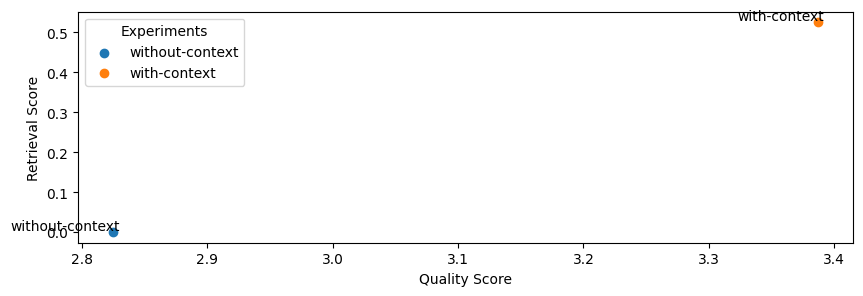

In [ ]:
scores = {}
for experiment_name in ["without-context", "with-context"]:
    scores[experiment_name] = print_experiment(experiment_name, EXPERIMENTS_DIR)
plot_scores(scores=scores)

**Sanity check**: the retrieval score for without-context is zero since we’re using any context.

As we can see, using context (RAG) does indeed help in the quality of our answers (and by a meaningful margin).

### Chunk size

Next, we'll access various chunk sizes. Smaller chunks (but not too small!) are able to encapsulate atomic concepts which yields more precise retrieval. While larger chunks may be more noisy. Popular strategies include using small chunks but retrieving a bit of the [surrounding chunks](https://gpt-index.readthedocs.io/en/latest/end_to_end_tutorials/dev_practices/production_rag.html#decoupling-chunks-used-for-retrieval-vs-chunks-used-for-synthesis) around it (since it may have relevnat info) or store [mulitple embeddings](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector) per document (ex. summary embedding per document).

In [ ]:
experiment_names = []
chunk_sizes = [100, 300, 500, 700, 900]

In [ ]:
for chunk_size in chunk_sizes:
    experiment_name = f"chunk-size-{chunk_size}"
    experiment_names.append(experiment_name)
    run_experiment(
        experiment_name=experiment_name, 
        chunk_size=chunk_size, 
        chunk_overlap=50, 
        num_chunks=5,
        embedding_model_name=embedding_model_name,
        embedding_dim=EMBEDDING_DIMENSIONS[embedding_model_name],
        llm=llm,
        evaluator=EVALUATOR,
        docs_dir=DOCS_DIR, 
        experiments_dir=EXPERIMENTS_DIR, 
        references_fp=REFERENCES_FILE_PATH,
        num_samples=NUM_SAMPLES)

<IPython.core.display.JSON object>

100%|██████████| 177/177 [17:51<00:00,  6.06s/it]


chunk-size-100
  retrieval score: 0.4180790960451977
  quality score: 3.019774011299435

chunk-size-300
  retrieval score: 0.5254237288135594
  quality score: 3.4124293785310735

chunk-size-500
  retrieval score: 0.5480225988700564
  quality score: 3.446327683615819

chunk-size-700
  retrieval score: 0.519774011299435
  quality score: 3.516949152542373

chunk-size-900
  retrieval score: 0.5706214689265536
  quality score: 3.480225988700565



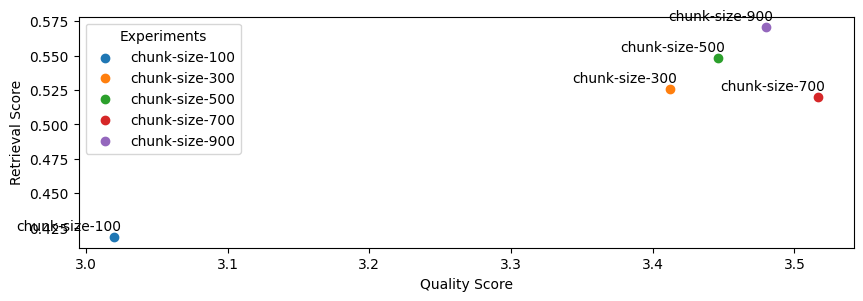

In [ ]:
scores = {}
for experiment_name in experiment_names:
    scores[experiment_name] = print_experiment(experiment_name, EXPERIMENTS_DIR)
plot_scores(scores=scores)

It appears that larger chunk sizes do help but tapers off (too much context might be too noisy). Larger chunk sizes [aren’t always better](https://arxiv.org/abs/2307.03172).

**Note**: If we were to use larger chunk sizes (ours is based on characters), keep in mind that [most](https://huggingface.co/spaces/mteb/leaderboard) open source embedding models have a maximum sequence length of 512 sub-word tokens. This means that if our chunk contains more than 512 sub-word tokens (4 chars ≈ 1 token), the embedding wouldn't account for it anyway (unless we finetune our embedding model to have longer sequence lengths).

In [ ]:
CHUNK_SIZE = 700
CHUNK_OVERLAP = 50

### Number of chunks

Next, we'll experiment with the number of chunks to use. More chunks will allow us to add more context but too many could potentially introduce a lot of noise.

**Note**: The `chunk_size` we chose multiplied by the `num_chunks` below fits inside the LLM's context length. We're experimenting with the chunk size and number of chunks as if they were indepdent variables but they area heavily related. Especially since all of our LLMs have a finite maximum context length. So ideally, we would tune for a combination if `chunk_size` * `num_chunks`.

In [ ]:
experiment_names = []
num_chunks_list = [1, 3, 5, 7, 9]

In [ ]:
for num_chunks in num_chunks_list:
    experiment_name = f"num-chunks-{num_chunks}"
    experiment_names.append(experiment_name)
    run_experiment(
        experiment_name=experiment_name,
        chunk_size=CHUNK_SIZE, 
        chunk_overlap=CHUNK_OVERLAP, 
        num_chunks=num_chunks,
        embedding_model_name=embedding_model_name,
        embedding_dim=EMBEDDING_DIMENSIONS[embedding_model_name],
        llm=llm,
        evaluator=EVALUATOR,
        docs_dir=DOCS_DIR, 
        experiments_dir=EXPERIMENTS_DIR, 
        references_fp=REFERENCES_FILE_PATH,
        num_samples=NUM_SAMPLES)

<IPython.core.display.JSON object>

100%|██████████| 177/177 [23:34<00:00,  7.99s/it]


num-chunks-1
  retrieval score: 0.2542372881355932
  quality score: 3.1807909604519775

num-chunks-3
  retrieval score: 0.4689265536723164
  quality score: 3.463276836158192

num-chunks-5
  retrieval score: 0.519774011299435
  quality score: 3.5028248587570623

num-chunks-7
  retrieval score: 0.6271186440677966
  quality score: 3.516949152542373

num-chunks-9
  retrieval score: 0.6836158192090396
  quality score: 3.5395480225988702



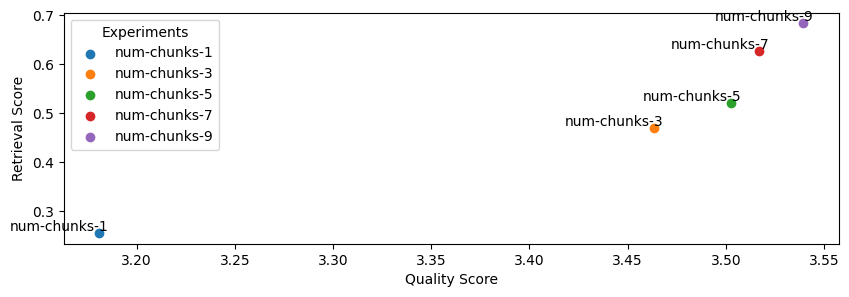

In [ ]:
scores = {}
for experiment_name in experiment_names:
    scores[experiment_name] = print_experiment(experiment_name, EXPERIMENTS_DIR)
plot_scores(scores=scores)

Increasing our number of chunks improves our retrieval and quality scores. We had to stop testing at `num_chunks` of 9 because we started to hit maximum context length often. This is a compelling reason to invest in extending context size via RoPE scaling (rotary position embeddings), etc.


In [ ]:
NUM_CHUNKS = 9

### Embedding models

So far, we've used [thenlper/gte-base](https://huggingface.co/thenlper/gte-base) as our embedding model because it's a relatively small (0.22 GB) and performant option. But now, let's explore other popular options such as the current leader on the [MTEB leaderboard](https://huggingface.co/spaces/mteb/leaderboard), [BAAI/bge-large-en](https://huggingface.co/BAAI/bge-large-en) (1.34 GB), [thenlper/gte-large](https://huggingface.co/thenlper/gte-large) (a larger version of `gte-base`), and OpenAI's [text-embedding-ada-002](https://openai.com/blog/new-and-improved-embedding-model).

In [ ]:
experiment_names = []
embedding_model_names = ["thenlper/gte-base", "thenlper/gte-large", "BAAI/bge-large-en", "text-embedding-ada-002"]

In [ ]:
for embedding_model_name in embedding_model_names:
    experiment_name = f"{embedding_model_name.split('/')[-1]}"
    experiment_names.append(experiment_name)
    run_experiment(
        experiment_name=experiment_name, 
        chunk_size=CHUNK_SIZE, 
        chunk_overlap=CHUNK_OVERLAP, 
        num_chunks=NUM_CHUNKS,
        embedding_model_name=embedding_model_name,
        embedding_dim=EMBEDDING_DIMENSIONS[embedding_model_name],
        llm=llm,
        evaluator=EVALUATOR,
        docs_dir=DOCS_DIR, 
        experiments_dir=EXPERIMENTS_DIR, 
        references_fp=REFERENCES_FILE_PATH,
        num_samples=NUM_SAMPLES)

<IPython.core.display.JSON object>

100%|██████████| 177/177 [21:41<00:00,  7.35s/it]


gte-base
  retrieval score: 0.6836158192090396
  quality score: 3.519774011299435

gte-large
  retrieval score: 0.7288135593220338
  quality score: 3.573446327683616

bge-large-en
  retrieval score: 0.4180790960451977
  quality score: 3.2344632768361583

text-embedding-ada-002
  retrieval score: 0.6497175141242938
  quality score: 3.5706214689265536



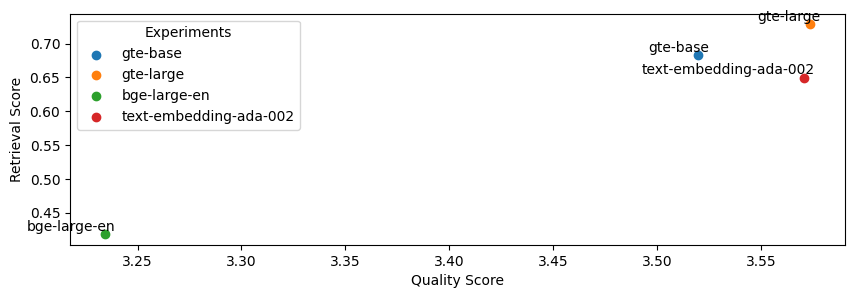

In [ ]:
scores = {}
for experiment_name in experiment_names:
    scores[experiment_name] = print_experiment(experiment_name, EXPERIMENTS_DIR)
plot_scores(scores=scores)

This is an interesting outcome because the #1 (`BAAI/bge-large-en`) on the current [leaderboard](https://huggingface.co/spaces/mteb/leaderboard) isn't necessarily the best for our specific task. Using the smaller `thenlper/gte-large` produced the best retrieval and quality scores in our experiments.

In [ ]:
EMBEDDING_MODEL_NAME = "thenlper/gte-large"

### OSS vs. closed LLMs

We're now going to use the best configurations from above to evaluate different choices for the main LLM.

**Note**:
- We've been using a specific LLM so far to decide on the configuration so that specific LLM's performance here will be a bit biased.
- This list is not exhaustive and even for the LLMs we use, there are versions with longer context windows available.

In [ ]:
experiment_names = []
llms = ["gpt-3.5-turbo",
        "gpt-4",
        "gpt-4-1106-preview",
        "meta-llama/Llama-2-7b-chat-hf", 
        "meta-llama/Llama-2-13b-chat-hf", 
        "meta-llama/Llama-2-70b-chat-hf",
        "codellama/CodeLlama-34b-Instruct-hf",
        "mistralai/Mistral-7B-Instruct-v0.1",
        "mistralai/Mixtral-8x7B-Instruct-v0.1"]

In [ ]:
for llm in llms:
    experiment_name = f"{llm.split('/')[-1].lower()}"
    experiment_names.append(experiment_name)
    run_experiment(
        experiment_name=experiment_name, 
        chunk_size=CHUNK_SIZE, 
        chunk_overlap=CHUNK_OVERLAP, 
        num_chunks=NUM_CHUNKS,
        embedding_model_name=EMBEDDING_MODEL_NAME,
        embedding_dim=EMBEDDING_DIMENSIONS[EMBEDDING_MODEL_NAME],
        llm=llm,
        evaluator=EVALUATOR,
        docs_dir=DOCS_DIR, 
        experiments_dir=EXPERIMENTS_DIR, 
        references_fp=REFERENCES_FILE_PATH,
        num_samples=NUM_SAMPLES)

<IPython.core.display.JSON object>

100%|██████████| 177/177 [13:18<00:00,  4.51s/it]


In [ ]:
scores = {}
for experiment_name in experiment_names:
    scores[experiment_name] = print_experiment(experiment_name, EXPERIMENTS_DIR)

gpt-3.5-turbo
  retrieval score: 0.7288135593220338
  quality score: 3.559322033898305

gpt-4
  retrieval score: 0.7288135593220338
  quality score: 3.8728813559322033

gpt-4-1106-preview
  retrieval score: 0.7288135593220338
  quality score: 4.209039548022599

llama-2-7b-chat-hf
  retrieval score: 0.7288135593220338
  quality score: 3.2966101694915255

llama-2-13b-chat-hf
  retrieval score: 0.7288135593220338
  quality score: 3.4152542372881354

llama-2-70b-chat-hf
  retrieval score: 0.7288135593220338
  quality score: 3.598870056497175

codellama-34b-instruct-hf
  retrieval score: 0.7288135593220338
  quality score: 3.593220338983051

mistral-7b-instruct-v0.1
  retrieval score: 0.7288135593220338
  quality score: 3.440677966101695

mixtral-8x7b-instruct-v0.1
  retrieval score: 0.7288135593220338
  quality score: 3.943502824858757



**Sanity check**: the retrieval scores are all the same because the LLM we choose doesn’t impact that part of our application.

Both `codellama-34b` and `llama-70b` outperform the other OSS LLMs. `codellama-34b` is also half the size and trained on code datasets as well. And our use case here often involves queries or contexts related to code.

In [ ]:
LLM = "mistralai/Mixtral-8x7B-Instruct-v0.1"

**Note**: Some of our LLMs have much larger context lengths, ex. `gpt-4` is 8192 tokens and `gpt-3.5-turbo-16k` is 16,384 tokens. We could increase the number of chunks that we use for these since we saw that increasing `num_chunks` continued to improve the retrieval and quality scores. However, we will keep this value fixed for now since the performance started to taper off anyway and so we can compare these performances under the exact same configurations. 

### MoEs without context

Curious how well these mixture of experts (MoE) fare without any context.

In [ ]:
experiment_names = []
moes = ["gpt-4",
        "gpt-4-1106-preview",
        "mistralai/Mixtral-8x7B-Instruct-v0.1"]

In [ ]:
for moe in moes:
    experiment_name = f"without-context-{moe.split('/')[-1].lower()}"
    experiment_names.append(experiment_name)
    run_experiment(
        experiment_name=experiment_name, 
        chunk_size=CHUNK_SIZE, 
        chunk_overlap=CHUNK_OVERLAP, 
        num_chunks=0,  # no retrieved context
        embedding_model_name=EMBEDDING_MODEL_NAME,
        embedding_dim=EMBEDDING_DIMENSIONS[EMBEDDING_MODEL_NAME],
        llm=moe,
        evaluator=EVALUATOR,
        docs_dir=DOCS_DIR, 
        experiments_dir=EXPERIMENTS_DIR, 
        references_fp=REFERENCES_FILE_PATH,
        num_samples=NUM_SAMPLES)

<IPython.core.display.JSON object>

100%|██████████| 177/177 [12:13<00:00,  4.14s/it]


In [ ]:
scores = {}
for experiment_name in experiment_names:
    scores[experiment_name] = print_experiment(experiment_name, EXPERIMENTS_DIR)

without-context-gpt-4
  retrieval score: 0.0
  quality score: 1.4887005649717515

without-context-gpt-4-1106-preview
  retrieval score: 0.0
  quality score: 3.8163841807909606

without-context-mixtral-8x7b-instruct-v0.1
  retrieval score: 0.0
  quality score: 3.189265536723164



# Fine-tuning

Everything we have explored so far involves optimizing for how our data is preprocessed and using our models (embedding, LLM, etc.) as is. However, it's also worth exploring fine-tuning our models with data unique to our use case. This could help us better represent our data and ultimately increase our retrieval and quality scores. In this section, we're going to fine-tune our embedding model. The intuition here is that it may be worth it to learn a more contextual representation of our tokens than the default embedding models can. This can especially be impactful if we have a lot of:
- new tokens that the default tokenization process creates subtokens out of that lose the significance of the token
- existing tokens that have contextually different meanings in our use case

<img width="800" src="https://images.ctfassets.net/xjan103pcp94/4G5324lsDZwq0jES7uBH0l/a715cd50af7061e1b3c57ec3e8038f05/rag-based-llm-applications-finetune-embeddings.png">

When it comes to fine-tuning our embedding model, we will exploring two approaches:
- **full parameter**: including the embedding layer and all subsequent encoder layers (transformer blocks)
- **embedding layer**: to better represent our unique subtokens and avoid overfitting (version of linear adapter)

**Note**: we will not be exploring fine-tuning our LLM in this section because our previous [experiments](https://www.anyscale.com/blog/fine-tuning-llama-2-a-comprehensive-case-study-for-tailoring-models-to-unique-applications) ([LoRa vs. full parameter](https://www.anyscale.com/blog/fine-tuning-llms-lora-or-full-parameter-an-in-depth-analysis-with-llama-2)) have shown that fine-tuning has helped tremendously with [form not facts](https://www.anyscale.com/blog/fine-tuning-is-for-form-not-facts), which in our case won't help too much (compared to for ex. SQL generation). However, your use cases might benefit from fine-tuning, so be sure to check out our [Anyscale Endpoints fine-tuning](https://www.anyscale.com/endpoints) to easily tune and serve models (fully hosted or private on your cloud).

## Synthetic dataset

Our first step will be to create a dataset to fine-tune our embedding model on. Our current embedding models have been trained via self-supervised learning (word2vec, GloVe, next/masked token prediction, etc.) and so we will continue fine-tuning with a self-supervised workflow. We're going to reuse a very similar approach as our cold start QA dataset section earlier so that we can map sections in our data to questions. The fine-tuning task here will be for the model to determine which sections in our dataset maps best to the input query. This optimization task will allow our embedding model to learn better representations of tokens in our dataset.

**Note**: While we could create a dataset mapping section titles with section text, we are creating a synthetic Q&A dataset because it will be most representative of the types of data we want to learn how to embed.

Our prompt is going to be a bit different because we want to generate a variety of different questions and we're going to use `llama-70b` here so that we can scale this QA generation process (and avoid any rate limits). To be thorough, we're going to generate one question from every section in our dataset so that we can try to capture as many unique tokens as possible.

In [ ]:
system_content = f"""
Create one question using only the context provided starting with "What", "How" or "Why".
Only respond with the question, don't say anything else (unecessary starting words, hints, etc.)
"""

In [ ]:
# Generate questions
embedding_qa = []
sections = sections_ds.take_all()
max_context_length = int(0.5*MAX_CONTEXT_LENGTHS[LLM]-get_num_tokens(system_content))
for section in tqdm(sections):
    user_content = trim(
        text=f"context: {section['text']}", 
        max_context_length=max_context_length)
    response = generate_response(
        llm="meta-llama/Llama-2-70b-chat-hf",
        temperature=0.0,
        stream=False,
        system_content=system_content,
        user_content=user_content,
        max_retries=1)
    if response:
        embedding_qa.append({"question": response, "source": section["source"]})
print (len(embedding_qa))

100%|██████████| 5727/5727 [2:45:43<00:00,  1.74s/it]  


5727

In [ ]:
# Path
EMBEDDING_QA_FILE_PATH = Path(ROOT_DIR, "datasets", "embedding_qa.json")
EMBEDDING_QA_FILE_PATH.parent.mkdir(parents=True, exist_ok=True)

In [ ]:
# Save to file
with open(EMBEDDING_QA_FILE_PATH, "w") as fp:
    json.dump(embedding_qa, fp, indent=4)

## Training data

We're now going to split our dataset into training and validation splits.

In [ ]:
from sentence_transformers import InputExample

In [ ]:
# Load from file
with open(EMBEDDING_QA_FILE_PATH, "r") as fp:
    embedding_qa = json.load(fp)

In [ ]:
# Split counts
num_train_samples = int(len(embedding_qa)*0.8)
emb_qa_train = embedding_qa[:num_train_samples]
emb_qa_val = embedding_qa[num_train_samples:]

In [ ]:
# Training dataset
train_dataset = []
for item in tqdm(emb_qa_train):
    query = item["question"]
    source_text = fetch_text(item["source"])
    example = InputExample(texts=[query, source_text])
    train_dataset.append(example)

100%|██████████| 4581/4581 [03:37<00:00, 21.05it/s]


## Validation

Our validation evaluation criteria involves an information retrieval (IR) evaluator that will retrieve the top k similar documents from the corpus for each query. The [InformationRetrievalEvaluator](https://www.sbert.net/docs/package_reference/evaluation.html#sentence_transformers.evaluation.InformationRetrievalEvaluator) requires the following inputs:

- queries: `Dict[str, str]`  #  qid => query
- corpus: `Dict[str, str]`  #  cid => doc
- relevant_docs: `Dict[str, Set[str]]`  #  qid => Set[cid]

**Note**: While our dataset may have multiple valid sections for a particular query, we will treat all other sections besides the one used to generate the query, as negative samples. This isn't an ideal scenario but the noise introduced is minimal, especially since we are using this to tune a representation layer (and not for a classification task).

In [ ]:
from sentence_transformers.evaluation import InformationRetrievalEvaluator

In [ ]:
# Validation dataset
queries, corpus, relevant_docs = {}, {}, {}
for i, item in tqdm(enumerate(emb_qa_val), total=len(emb_qa_val)):
    queries[f"qid_{i}"] = item["question"]
    corpus[f"cid_{i}"] = fetch_text(item["source"])
    relevant_docs[f"qid_{i}"] = set([f"cid_{i}"])
evaluator = InformationRetrievalEvaluator(queries, corpus, relevant_docs)

100%|██████████| 1146/1146 [01:30<00:00, 12.71it/s]


We'll be using [MultipleNegativesRankingLoss](https://www.sbert.net/docs/package_reference/losses.html#multiplenegativesrankingloss) as our loss function. It will use the data points (`InputExample(texts=[query, source_text])` in our training data as positive pairs and all other combinations as negative pairs. And the objective will be to increase the cosine similarity (default `similarity_fct`) for our positive pair and decrease it for the other pairs.

In [ ]:
# Custom callback to view validation performance
def val_callback(score, epoch, steps):
    print (f"EPOCH: {epoch}, VAL SCORE:{score:.4f}\n")

## Embedding model

Now we're ready to initialize our embedding model for fine-tuning.

In [ ]:
from sentence_transformers import SentenceTransformer

In [ ]:
embedding_model = SentenceTransformer(EMBEDDING_MODEL_NAME)
embedding_model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 1024, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

## Resize Tokenizer

While our tokenizer can represent new subtokens that are part of the vocabulary, it might be very helpful to explicitly add new tokens to our base model (BertModel) in our cast to our transformer. And then we can use [resize_token_embeddings](https://huggingface.co/docs/transformers/main_classes/model#transformers.PreTrainedModel.resize_token_embeddings) to adjust the model's embedding layer prior to fine-tuning. This can be very useful for contextual use cases, especially if many tokens are new or existing tokens have a very different meaning in our context.

In [ ]:
import re

In [ ]:
def get_unique_words(texts):
    all_text = " ".join(texts)  # join all texts
    all_text = all_text.replace("_", " ")  # replace underscores (ex. variable names)
    words = re.findall(r'\b[a-zA-Z]+\b', all_text)  # only letters
    words = [word.lower() for word in words]  # lower
    return set(words)

In [ ]:
# Get tokens that are OOV (out of vocabulary)
new_words = []
vocab = embedding_model.tokenizer.get_vocab().keys()
texts = [section["text"] for section in sections_ds.take_all()]
unique_words = get_unique_words(texts=texts)
for word in tqdm(unique_words):
    if word not in vocab:
        new_words.append(word)

100%|██████████| 11204/11204 [00:00<00:00, 1932515.61it/s]


In [ ]:
# Inspect
print (len(new_words))
print (new_words[:10])

5790
['activityoptions', 'subordinates', 'collateddata', 'placementgroup', 'alwayas', 'simplistic', 'mkl', 'constants', 'aggtype', 'wrapper']


In [ ]:
# Add new words to tokenizer
print (len(embedding_model.tokenizer))
embedding_model.tokenizer.add_tokens(new_words)
print (len(embedding_model.tokenizer))

30522
36312


In [ ]:
# Resize tokenizer
print (embedding_model._modules["0"]._modules["auto_model"]._modules["embeddings"]._modules["word_embeddings"])
embedding_model._modules["0"]._modules["auto_model"].resize_token_embeddings(len(embedding_model.tokenizer))
embedding_model._modules["0"]._modules["auto_model"]._modules["embeddings"]._modules["word_embeddings"].padding_idx = 0
print (embedding_model._modules["0"]._modules["auto_model"]._modules["embeddings"]._modules["word_embeddings"])

Embedding(30522, 1024, padding_idx=0)
Embedding(36312, 1024, padding_idx=0)


## Full parameter

Our full parameter fine-tuning approach will tune all of the following weights:

In [ ]:
embedding_model._modules["0"]._modules

OrderedDict([('auto_model',
              BertModel(
                (embeddings): BertEmbeddings(
                  (word_embeddings): Embedding(36312, 1024, padding_idx=0)
                  (position_embeddings): Embedding(512, 1024)
                  (token_type_embeddings): Embedding(2, 1024)
                  (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
                  (dropout): Dropout(p=0.1, inplace=False)
                )
                (encoder): BertEncoder(
                  (layer): ModuleList(
                    (0-23): 24 x BertLayer(
                      (attention): BertAttention(
                        (self): BertSelfAttention(
                          (query): Linear(in_features=1024, out_features=1024, bias=True)
                          (key): Linear(in_features=1024, out_features=1024, bias=True)
                          (value): Linear(in_features=1024, out_features=1024, bias=True)
                          (dropout): Dropout(p=

In [ ]:
from sentence_transformers.losses import MultipleNegativesRankingLoss
from torch.utils.data import DataLoader

In [ ]:
# Training setup
num_epochs = 2
batch_size = 4
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
loss = MultipleNegativesRankingLoss(embedding_model) # MNR Loss
warmup_steps = int(0.1 * num_epochs * len(train_dataloader))  # not used

In [ ]:
# Train
experiment_name = "gte-large-fine-tuned-fp"
embedding_model_path = str(Path(EFS_DIR, experiment_name))
embedding_model.fit(
    train_objectives=[(train_dataloader, loss)],
    epochs=num_epochs,
    warmup_steps=0,
    optimizer_params={"lr": 1e-8},
    weight_decay=0,
    output_path=embedding_model_path,
    show_progress_bar=True,
    evaluator=evaluator,
    callback=val_callback)

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1146 [00:00<?, ?it/s]

EPOCH: 0, VAL SCORE:0.5242



Iteration:   0%|          | 0/1146 [00:00<?, ?it/s]

EPOCH: 1, VAL SCORE:0.5282



In [ ]:
# Clean up
import gc
import torch
del embedding_model, loss
gc.collect()
torch.cuda.empty_cache()

Now we're ready to actually apply this fine-tuned embedding model on our test evaluation dataset. We can simply pass in our model artifact directory for the `embedding_model_name` because [HuggingFaceEmbeddings](https://api.python.langchain.com/en/latest/embeddings/langchain.embeddings.huggingface.HuggingFaceEmbeddings.html) accepts a string that can be either a directory or the model's name. If a directory matches with the input string, then it will load the model from that location first before trying to search on HF's hub.

In [ ]:
sql_dump_fp = Path(EFS_DIR, "sql_dumps", f"{experiment_name}_{CHUNK_SIZE}_{CHUNK_OVERLAP}.sql")
run_experiment(
    experiment_name=experiment_name, 
    chunk_size=CHUNK_SIZE, 
    chunk_overlap=CHUNK_OVERLAP, 
    num_chunks=NUM_CHUNKS,
    embedding_model_name=embedding_model_path,
    embedding_dim=EMBEDDING_DIMENSIONS[EMBEDDING_MODEL_NAME],
    llm=llm,  # ensure same model as we did for embedding model experiments
    evaluator=EVALUATOR,
    docs_dir=DOCS_DIR, 
    experiments_dir=EXPERIMENTS_DIR, 
    references_fp=REFERENCES_FILE_PATH,
    num_samples=NUM_SAMPLES,
    sql_dump_fp=sql_dump_fp)

<IPython.core.display.JSON object>

100%|██████████| 177/177 [14:34<00:00,  4.94s/it]


In [ ]:
embedding_model_names.append(experiment_name)
experiment_names = []
for embedding_model_name in embedding_model_names:
    experiment_names.append(f"{embedding_model_name.split('/')[-1]}")

gte-base
  retrieval score: 0.6836158192090396
  quality score: 3.519774011299435

gte-large
  retrieval score: 0.7288135593220338
  quality score: 3.573446327683616

bge-large-en
  retrieval score: 0.4180790960451977
  quality score: 3.2344632768361583

text-embedding-ada-002
  retrieval score: 0.6497175141242938
  quality score: 3.5706214689265536

gte-large-fine-tuned-fp
  retrieval score: 0.4463276836158192
  quality score: 3.378531073446328



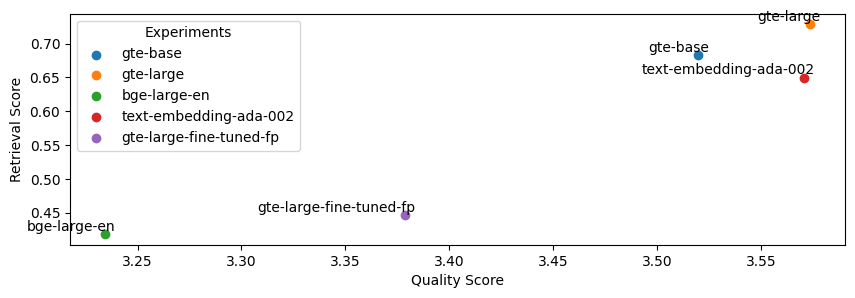

In [ ]:
scores = {}
for experiment_name in experiment_names:
    scores[experiment_name] = print_experiment(experiment_name, EXPERIMENTS_DIR)
plot_scores(scores=scores)

This didn't really improve our overall application's retrieval or quality score. This doesn't necessarily mean that fine-tuning is not useful but might not always be worth the effort.
- synthetic data is not exactly like the types of questions that users ask (might be worth creating a dataset of more realistic queries or prompt tuning for more synthetic data that is more representative of user queries).
- fine-tuning the entire embedding model on our small embedding dataset might be causing **overfitting**.
- our experiment's evaluation is on a small dataset so slightly tuning embeddings via MNR may not increase retrieval recall much/if at all.

## Embedding layer

To help mitigate the overfitting, we can avoid retraining the entire embedding model and freeze all layers except for the embedding layer (word/subtoken embedding only, not the positional or token type layers). **Note**: this approach is somewhat similar to training a separate linear adapter (which we evaluation results for) except that it's larger and requires rebuilding the index.

In [ ]:
import torch
import torch.nn as nn

In [ ]:
# Reinitialize base embedding model
embedding_model = SentenceTransformer(EMBEDDING_MODEL_NAME)
embedding_model._modules["0"]._modules["auto_model"]._modules["embeddings"]

BertEmbeddings(
  (word_embeddings): Embedding(30522, 1024, padding_idx=0)
  (position_embeddings): Embedding(512, 1024)
  (token_type_embeddings): Embedding(2, 1024)
  (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [ ]:
# Unfreeze embedding layers
for param in embedding_model._modules["0"]._modules["auto_model"]._modules["embeddings"].parameters():
    param.requires_grad = True

In [ ]:
# Freeze Bert encoder layers
for param in embedding_model._modules["0"]._modules["auto_model"]._modules["encoder"].parameters():
    param.requires_grad = False

In [ ]:
# Training setup
num_epochs = 2
batch_size = 4
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
loss = MultipleNegativesRankingLoss(embedding_model)
warmup_steps = int(0.1 * num_epochs * len(train_dataloader))  # not used

In [ ]:
# Train
experiment_name = "gte-large-fine-tuned-el"
embedding_model_path = str(Path(EFS_DIR, experiment_name))
embedding_model.fit(
    train_objectives=[(train_dataloader, loss)],
    epochs=num_epochs,
    warmup_steps=0,
    optimizer_params={"lr": 1e-5},
    weight_decay=0,
    output_path=embedding_model_path,
    show_progress_bar=True,
    evaluator=evaluator,
    callback=val_callback)

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1146 [00:00<?, ?it/s]

EPOCH: 0, VAL SCORE:0.7938



Iteration:   0%|          | 0/1146 [00:00<?, ?it/s]

EPOCH: 1, VAL SCORE:0.7965



In [ ]:
# Experiment
sql_dump_fp = Path(EFS_DIR, "sql_dumps", f"{experiment_name}_{CHUNK_SIZE}_{CHUNK_OVERLAP}.sql")
run_experiment(
    experiment_name=experiment_name, 
    chunk_size=CHUNK_SIZE,
    chunk_overlap=CHUNK_OVERLAP, 
    num_chunks=NUM_CHUNKS,
    embedding_model_name=embedding_model_path,
    embedding_dim=EMBEDDING_DIMENSIONS[EMBEDDING_MODEL_NAME],
    llm=llm,  # ensure same model as we did for embedding model experiments
    evaluator=EVALUATOR,
    docs_dir=DOCS_DIR, 
    experiments_dir=EXPERIMENTS_DIR, 
    references_fp=REFERENCES_FILE_PATH,
    num_samples=NUM_SAMPLES,
    sql_dump_fp=sql_dump_fp)

<IPython.core.display.JSON object>

100%|██████████| 177/177 [13:37<00:00,  4.62s/it]


In [ ]:
embedding_model_names.append(experiment_name)
experiment_names = []
for embedding_model_name in embedding_model_names:
    experiment_names.append(f"{embedding_model_name.split('/')[-1]}")

gte-base
  retrieval score: 0.6836158192090396
  quality score: 3.519774011299435

gte-large
  retrieval score: 0.7288135593220338
  quality score: 3.573446327683616

bge-large-en
  retrieval score: 0.4180790960451977
  quality score: 3.2344632768361583

text-embedding-ada-002
  retrieval score: 0.6497175141242938
  quality score: 3.5706214689265536

gte-large-fine-tuned-fp
  retrieval score: 0.4463276836158192
  quality score: 3.378531073446328

gte-large-fine-tuned-el
  retrieval score: 0.7344632768361582
  quality score: 3.5819209039548023

gte-large-fine-tuned-el
  retrieval score: 0.7344632768361582
  quality score: 3.5819209039548023



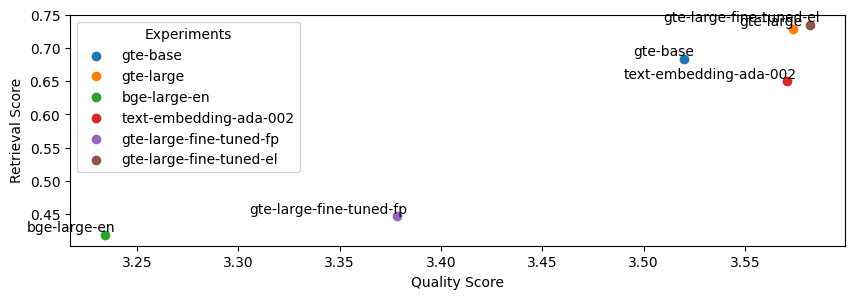

In [ ]:
scores = {}
for experiment_name in experiment_names:
    scores[experiment_name] = print_experiment(experiment_name, EXPERIMENTS_DIR)
plot_scores(scores=scores)

Much better validation scores and overall better performance but it's not worth the effort compared to using our base gte-large embedding model. This again can be improved with larger/higher quality datasets and perhaps even a larger testing dataset to capture small improvements in our retrieval scores.

In [ ]:
experiment_name = "gte-large-fine-tuned-el"
EMBEDDING_MODEL_PATH = str(Path(EFS_DIR, experiment_name))  # can pass this in directly for embedding_model_name
SQL_DUMP_FP = Path(EFS_DIR, "sql_dumps", f"{experiment_name}_{CHUNK_SIZE}_{CHUNK_OVERLAP}.sql")

# Prompt engineering

There's too much we can do when it comes to engineering the prompt (x-of-thought, multimodal, self-refine, query decomposition, etc.) so we're going to try out just a few interesting ideas. We're going to allow the LLM to ignore anything not relevant. The idea here is to show how quickly we can go from prompt engineering to evaluation report.

<img width="800" src="https://images.ctfassets.net/xjan103pcp94/6nMOu5sm3jploFUXeKxog2/1e4405924686798b243eb80ff5b8d549/Screenshot_2023-11-01_at_2.40.56_PM.png">

In [ ]:
system_content = "Answer the query using the context provided. Be succinct. " \
    "Contexts are organized in a list of dictionaries [{'text': <context>}, {'text': <context>}, ...]. " \
    "Feel free to ignore any contexts in the list that don't seem relevant to the query. "

In [ ]:
# Evaluate
experiment_name = "prompt-ignore-contexts"
run_experiment(
    experiment_name=experiment_name, 
    chunk_size=CHUNK_SIZE, 
    chunk_overlap=CHUNK_OVERLAP, 
    num_chunks=NUM_CHUNKS,
    embedding_model_name=EMBEDDING_MODEL_NAME,
    embedding_dim=EMBEDDING_DIMENSIONS[EMBEDDING_MODEL_NAME],
    llm=LLM,
    evaluator=EVALUATOR,
    docs_dir=DOCS_DIR, 
    experiments_dir=EXPERIMENTS_DIR, 
    references_fp=REFERENCES_FILE_PATH,
    system_content=system_content,  # new prompt
    num_samples=NUM_SAMPLES,
    sql_dump_fp=SQL_DUMP_FP)

<IPython.core.display.JSON object>

100%|██████████| 177/177 [13:33<00:00,  4.60s/it]


In [ ]:
# Results
print_experiment(experiment_name, EXPERIMENTS_DIR)

prompt-ignore-contexts
  retrieval score: 0.7344632768361582
  quality score: 3.943502824858757



{'retrieval_score': 0.7344632768361582, 'quality_score': 3.943502824858757}

It seems this specific prompt engineering effort does improve the quality of our system (knowing which context is relevant requires domain knowledge of Ray which the model may not have developed). But, as we mentioned earlier, there are too many other ways we can engineer our prompt and we encourage you to explore more. What’s important here is that we have a **clean and simple way to evaluate anything** that we want to experiment with. However, we have empirically found that improving the quality of our retrieval system and the data flywheel (where we fix our documentation itself) has had a much larger impact on the overall quality of our system.

In [ ]:
SYSTEM_CONTENT = "Answer the query using the context provided. Be succinct."

# Lexical search

We're going to now supplement our vector embedding based search with traditional lexical search, which searches for exact token matches between our query and document chunks. Our intuition here is that lexical search can help identify chunks with exact keyword matches where semantic representation may fail to capture. Especially for tokens that are out-of-vocabulary (and so represented via subtokens) with our embedding model. But our embeddings based approach is still very advantageous for capturing implicit meaning, and so we're going to combine several retrieval chunks from both vector embeddings based search and lexical search.

<img width="800" src="https://images.ctfassets.net/xjan103pcp94/9eBIE4iw7SmTtVvANbkAq/8913fcbd10fc66fd8b59278642155609/rag-based-llm-applications-lexical-search.png">

In [ ]:
# Env vars
os.environ["EMBEDDING_DIM"] = f"{EMBEDDING_DIMENSIONS[EMBEDDING_MODEL_NAME]}"
os.environ["SQL_DUMP_FP"] = str(SQL_DUMP_FP)

In [ ]:
%%bash
# Ensure the right index in built in-memory
psql "$DB_CONNECTION_STRING" -c "DROP TABLE IF EXISTS document;"  # drop
sudo -u postgres psql -f ../migrations/vector-${EMBEDDING_DIM}.sql  # set up
psql "$DB_CONNECTION_STRING" -f $SQL_DUMP_FP  # load

In [ ]:
# Get chunks
with psycopg.connect(os.environ["DB_CONNECTION_STRING"]) as conn:
    register_vector(conn)
    with conn.cursor() as cur:
        cur.execute("SELECT id, text, source FROM document")
        chunks = cur.fetchall()

## BM25

Let's apply lexical search using [BM25](https://en.wikipedia.org/wiki/Okapi_BM25), which is a ranking algorithm that rewards unique token matches between our query and contexts.

In [ ]:
import re
from rank_bm25 import BM25Okapi

In [ ]:
# BM25 index
texts = [re.sub(r"[^a-zA-Z0-9]", " ", chunk[1]).lower().split() for chunk in chunks]
lexical_index = BM25Okapi(texts)

Similar to our `semantic_search` function to retrieve the relevant context, we can implement a search function to use our lexical index to retrieve relevant context.

In [ ]:
def lexical_search(index, query, chunks, k):
    query_tokens = query.lower().split()  # preprocess query
    scores = index.get_scores(query_tokens)  # get best matching (BM) scores
    indices = sorted(range(len(scores)), key=lambda i: -scores[i])[:k]  # sort and get top k
    lexical_context = [{
            "id": chunks[i][0], 
            "text": chunks[i][1], 
            "source": chunks[i][2], 
            "score": scores[i]} for i in indices]
    return lexical_context

In [ ]:
# Retrieve top-k docs
k = 3
query = "What is the default batch size for map_batches?"
top_docs = lexical_search(lexical_index, query, chunks, k=k)
for item in top_docs:
    print (item["source"])
    print (item["text"])
    print ()

https://docs.ray.io/en/master/data/transforming-data.html#configuring-batch-size
Configuring batch size#
Increasing batch_size improves the performance of vectorized transformations like
NumPy functions and model inference. However, if your batch size is too large, your
program might run out of memory. If you encounter an out-of-memory error, decrease your
batch_size.
Note
The default batch size depends on your resource type. If you’re using CPUs,
the default batch size is 4096. If you’re using GPUs, you must specify an explicit
batch size.

https://docs.ray.io/en/master/data/api/doc/ray.data.Dataset.map_batches.html#ray-data-dataset-map-batches
fn – The function or generator to apply to a record batch, or a class type
that can be instantiated to create such a callable. Callable classes are
only supported for the actor compute strategy. Note fn must be
pickle-able.
batch_size – The desired number of rows in each batch, or None to use
entire blocks as batches (blocks may contain differe

## Semantic

Comparing this with the retrieved sources with our existing vector embedding based search shows that the two approaches, while different, both retrieved relevant sources. So, we're going to combine both approaches and feed it into the context for our LLM for generation.

In [ ]:
# Embed query
embedding_model = HuggingFaceEmbeddings(model_name=EMBEDDING_MODEL_NAME)
embedding = np.array(embedding_model.embed_query(query))
len(embedding)

1024

In [ ]:
# Get context
with psycopg.connect(os.environ["DB_CONNECTION_STRING"]) as conn:
    register_vector(conn)
    with conn.cursor() as cur:
        cur.execute("SELECT * FROM document ORDER BY embedding <=> %s LIMIT %s", (embedding, k))
        rows = cur.fetchall()
        context = [{"text": row[1]} for row in rows]
        sources = [row[2] for row in rows]

In [ ]:
for i, item in enumerate(context):
    print (sources[i])
    print (item["text"])
    print ()

https://docs.ray.io/en/master/data/batch_inference.html#configuring-batch-size
# Specify that each input batch should be of size 2.
ds.map_batches(assert_batch, batch_size=2)
Caution
The default batch_size of 4096 may be too large for datasets with large rows
(for example, tables with many columns or a collection of large images).

https://docs.ray.io/en/master/data/transforming-data.html#configuring-batch-size
Configuring batch size#
Increasing batch_size improves the performance of vectorized transformations like
NumPy functions and model inference. However, if your batch size is too large, your
program might run out of memory. If you encounter an out-of-memory error, decrease your
batch_size.
Note
The default batch size depends on your resource type. If you’re using CPUs,
the default batch size is 4096. If you’re using GPUs, you must specify an explicit
batch size.

https://docs.ray.io/en/master/data/examples/pytorch_resnet_batch_prediction.html#model-inference
}
Then we use the map

## Experiment

Now let's incorporate this into our retrieval workflow by add it to our `generate.py/QueryAgent` class. The main change will be to include the additional sources from lexical search:
```python
def QueryAgent():
    def __call__(lexical_search_k=1, **kwargs):
        # Add lexical search results
        if self.lexical_index:
            lexical_context = lexical_search(
                index=self.lexical_index, query=query, chunks=self.chunks, k=lexical_search_k)
            # Insert after <lexical_search_k> worth of semantic results
            context_results[lexical_search_k:lexical_search_k] = lexical_context
```

In [ ]:
experiment_names = []
lexical_search_k_list = [1, 3, 5]

In [ ]:
# Experiment
use_lexical_search = True
for lexical_search_k in lexical_search_k_list:
    experiment_name = f"lexical-search-bm25-{lexical_search_k}"
    experiment_names.append(experiment_name)
    run_experiment(
        experiment_name=experiment_name, 
        chunk_size=CHUNK_SIZE, 
        chunk_overlap=CHUNK_OVERLAP, 
        num_chunks=NUM_CHUNKS,
        embedding_model_name=EMBEDDING_MODEL_NAME,
        embedding_dim=EMBEDDING_DIMENSIONS[EMBEDDING_MODEL_NAME],
        llm=LLM,
        evaluator=EVALUATOR,
        docs_dir=DOCS_DIR, 
        experiments_dir=EXPERIMENTS_DIR, 
        references_fp=REFERENCES_FILE_PATH,
        system_content=SYSTEM_CONTENT,
        use_lexical_search=use_lexical_search,
        lexical_search_k=lexical_search_k,
        num_samples=NUM_SAMPLES,
        sql_dump_fp=SQL_DUMP_FP)

<IPython.core.display.JSON object>

100%|██████████| 177/177 [12:39<00:00,  4.29s/it]


lexical-search-bm25-1
  retrieval score: 0.7344632768361582
  quality score: 3.926553672316384

lexical-search-bm25-3
  retrieval score: 0.751412429378531
  quality score: 3.790960451977401

lexical-search-bm25-5
  retrieval score: 0.768361581920904
  quality score: 3.8389830508474576



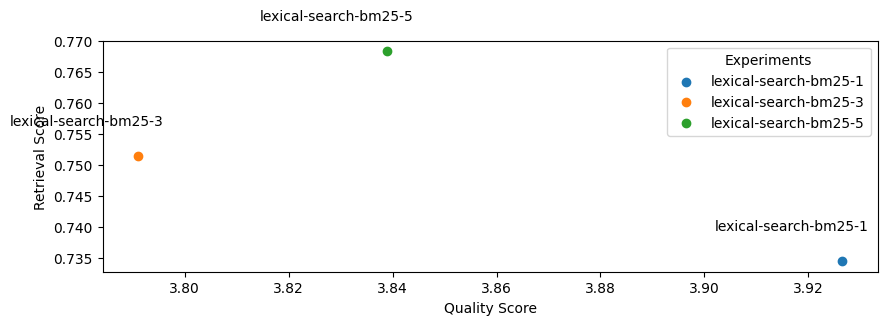

In [ ]:
scores = {}
for experiment_name in experiment_names:
    scores[experiment_name] = print_experiment(experiment_name, EXPERIMENTS_DIR)
plot_scores(scores=scores)

In [ ]:
USE_LEXICAL_SEARCH = False
LEXICAL_SEARCH_K = 0

It looks like lexical search improved our retrieval scores, which was expected since more chunks are added into the context. But it didn't really help improve our quality scores, perhaps the additional chunks added also introduced quite a bit of noise.

**Note**: This was just one aspect (keyword matching) of lexical search that we explored but there are many other useful features such as filtering, counts, etc. It's also worth exploring how we combine the lexical search results with semantic search results.

# Reranking

So far with all of our approaches, we've used an embedding model (+ lexical search) to identify the top k relevant chunks in our dataset. The number of chunks (k) has been a small number because we found that adding too many chunks did not help and our LLMs have restricted context lengths. However, this was all under the assumption that the top k retrieved chunks were truly the most relevant chunks and that their order was correct as well. What if increasing the number of chunks didn't help because some relevant chunks were much lower in the ordered list. And, semantic representations, while very rich, were not trained for this specific task. 

In this section, we'll implement reranking so that we can use our semantic and lexical search methods to cast a much wider net over our dataset (retrieve many chunks) and then rerank the order based on the user's query. The intuition here is that we can account for gaps in our semantic representations with ranking specific to our use case. We'll train a supervised model that predicts which part of our [documentation](https://docs.ray.io/) is most relevant for a given user's query. We'll use this prediction to then rerank the relevant chunks so that chunks from this part of our documentation are moved to the top of the list.

**Note**: We also experimented with [cross-encoders](https://www.sbert.net/docs/pretrained_cross-encoders.html) which processes the query and the relevant contexts together with the same model. This allows for a more contextual representation compared to cosine distance but it's also more computationally expensive. So we followed a similar approach of using the similarity distance first to extract many chunks and then use the cross-encoder to rerank and choose the top k chunks. Unfortunately, this approach didn't improve our quality as the technique below does but it's worth fine-tuning our cross-encoder using our synthetic embedding QA dataset.

<img width="800" src="https://images.ctfassets.net/xjan103pcp94/4bmoRNSzxtOyfToCtl68xq/d9727c41a3d435d1821eea5ab67c1e97/rag-based-llm-applications-reranking.png">

## Dataset

We're going to reuse the QA dataset we created in our fine-tuning section because that dataset has questions that map with specific sections.

In [ ]:
from collections import Counter
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [ ]:
def get_tag(url):
    return re.findall(r"docs\.ray\.io/en/master/([^/]+)", url)[0].split("#")[0]

In [ ]:
# Load data
from pathlib import Path
df = pd.read_json(Path(ROOT_DIR, "datasets", "embedding_qa.json"))
df["tag"] = df.source.map(get_tag)
df["section"] = df.source.map(lambda source: source.split("/")[-1])
df["text"] = df["section"] + " " + df["question"]
df.sample(n=5)

,question,source,tag,section,text
480,What is the purpose of the shim function in c...,https://docs.ray.io/en/master/tune/api/suggest...,tune,suggestion.html#shim-instantiation-tune-create...,suggestion.html#shim-instantiation-tune-create...
2723,What is the peak heap memory usage (in MiB) o...,https://docs.ray.io/en/master/data/api/doc/ray...,data,ray.data.Dataset.stats.html#ray-data-dataset-s...,ray.data.Dataset.stats.html#ray-data-dataset-s...
4375,What is the purpose of the 'is_training' prop...,https://docs.ray.io/en/master/rllib/package_re...,rllib,ray.rllib.policy.sample_batch.SampleBatch.is_t...,ray.rllib.policy.sample_batch.SampleBatch.is_t...
1627,"What is the purpose of the ""ray.init"" method ...",https://docs.ray.io/en/master/ray-core/api/doc...,ray-core,ray.init.html#ray-init,ray.init.html#ray-init What is the purpose of...
5254,What is the purpose of the gradient clipping ...,https://docs.ray.io/en/master/rllib/package_re...,rllib,ray.rllib.core.learner.learner.Learner._get_cl...,ray.rllib.core.learner.learner.Learner._get_cl...


In [ ]:
Counter(df.tag)

Counter({'rllib': 1269,
         'tune': 979,
         'train': 697,
         'cluster': 690,
         'data': 652,
         'ray-core': 557,
         'serve': 302,
         'ray-observability': 175,
         'ray-contribute': 95,
         'workflows': 82,
         'ray-air': 74,
         'ray-more-libs': 66,
         'ray-overview': 46,
         'rllib-env.html': 17,
         'installation.html': 16,
         'tune.html': 5,
         'joblib.html': 3,
         'ray-references': 2})

In [ ]:
# Map only what we want to keep
tags_to_keep = ["rllib", "tune", "train", "cluster", "ray-core", "data", "serve", "ray-observability"]
df["tag"] = df.tag.apply(lambda x: x if x in tags_to_keep else "other")
Counter(df.tag)

Counter({'rllib': 1269,
         'tune': 979,
         'train': 697,
         'cluster': 690,
         'data': 652,
         'ray-core': 557,
         'other': 406,
         'serve': 302,
         'ray-observability': 175})

In [ ]:
# Train and test data splits
test_size = 0.2
train_df, test_df = train_test_split(df, stratify=df.tag, test_size=test_size, random_state=1234)

## Preprocessing

We'll start by creating some preprocessing functions to better represent our data. For example, our documentation has many variables that are camel cased (ex. `RayDeepSpeedStrategy`). When a tokenizer is used on this, we often lose the individual tokens that we know to be useful and, instead, random subtokens are created.

**Note**: we didn't omnisciently know to create these unique preprocessing functions! This is all a result of methodical iteration. We train a model → view incorrect data points → view how the data was represented (ex. subtokenization) → update preprocessing → iterate ↺

In [ ]:
import re
from transformers import BertTokenizer

In [ ]:
def split_camel_case_in_sentences(sentences):
    def split_camel_case_word(word):
        return re.sub("([a-z0-9])([A-Z])", r"\1 \2", word)
    processed_sentences = []
    for sentence in sentences:
        processed_words = []   
        for word in sentence.split():
            processed_words.extend(split_camel_case_word(word).split())
        processed_sentences.append(" ".join(processed_words))
    return processed_sentences

In [ ]:
# Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
def preprocess(texts):
    texts = [re.sub(r'(?<=\w)([?.,!])(?!\s)', r' \1', text) for text in texts]
    texts = [text.replace("_", " ").replace("-", " ").replace("#", " ").replace(".html", "").replace(".", " ") for text in texts]
    texts = split_camel_case_in_sentences(texts)  # camelcase
    texts = [tokenizer.tokenize(text) for text in texts]  # subtokens
    texts = [" ".join(word for word in text) for text in texts]
    return texts

In [ ]:
print (preprocess(["RayDeepSpeedStrategy"]))
print (preprocess(["What is the default batch_size for map_batches?"]))

['ray deep speed strategy']
['what is the default batch size for map batch ##es ?']


## Model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

In [ ]:
# Train classifier
from rag.rerank import preprocess  # for pickle
reranker = Pipeline([
    ("preprocess", FunctionTransformer(preprocess)),
    ("vectorizer", TfidfVectorizer(lowercase=True)),
    ("classifier", LogisticRegression(multi_class="multinomial", solver="lbfgs"))
])
reranker.fit(train_df["text"].tolist(), train_df["tag"].tolist())

Pipeline(steps=[('preprocess',
                 FunctionTransformer(func=<function preprocess at 0x7f70338d3400>)),
                ('vectorizer', TfidfVectorizer()),
                ('classifier', LogisticRegression(multi_class='multinomial'))])

**Note**: we also trained a BERT classifier and while performance was better than our logistic classifier, these large networks suffer from [overconfidence](https://arxiv.org/abs/1706.04599) and we can't use a threshold based approach as we do below. And without the threshold approach (where we only rerank when the reranker is truly confident), then the quality score of our application does not improve.

## Inference

In [ ]:
import pickle

In [ ]:
# Save
reranker_fp = Path(EFS_DIR, "reranker.pkl")
with open(reranker_fp, "wb") as file:
    pickle.dump(reranker, file)

In [ ]:
# Load
reranker_fp = Path(EFS_DIR, "reranker.pkl")
with open(reranker_fp, "rb") as file:
    reranker = pickle.load(file)

In [ ]:
def custom_predict(inputs, classifier, threshold=0.2, other_label="other"):
    y_pred = []
    for item in classifier.predict_proba(inputs):
        prob = max(item)
        index = item.argmax()
        if prob >= threshold:
            pred = classifier.classes_[index]
        else:
            pred = other_label
        y_pred.append(pred)
    return y_pred

In [ ]:
# Test inference
question = "traning with deepspeed"
custom_predict([question], classifier=reranker)[0]

'train'

## Evaluation

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

In [ ]:
# Evaluation
metrics = {}
y_test = test_df["tag"]
y_pred = custom_predict(inputs=test_df["text"], classifier=reranker)

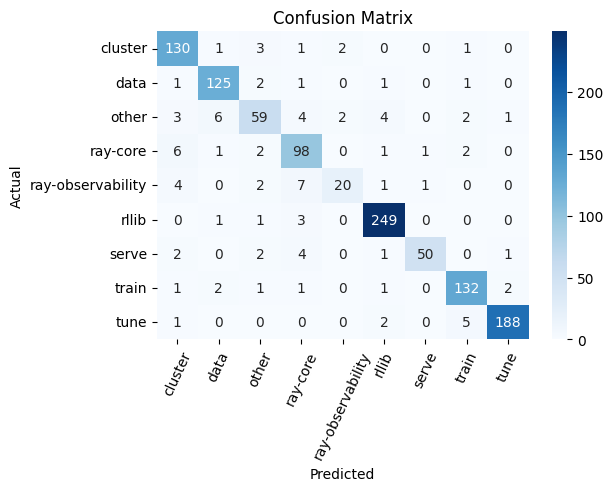

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=reranker.classes_, yticklabels=reranker.classes_)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix")
plt.xticks(rotation=65)
plt.show()

In [ ]:
# Metrics
overall_metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
metrics["precision"] = overall_metrics[0]
metrics["recall"] = overall_metrics[1]
metrics["f1"] = overall_metrics[2]
metrics["num_samples"] = np.float64(len(y_test))
print (json.dumps(metrics, indent=4))

{
    "precision": 0.9168129573272782,
    "recall": 0.9171029668411868,
    "f1": 0.9154520876579969,
    "num_samples": 1146.0
}


Precision will be the most important metric here because we will only apply reranking if the softmax probability of our predicted tag is above the threshold value.

## Testing

Besides just a metric based evaluation, we also want to assess how our model performs on some minimum functionality tests. We need all of these basic sanity checks to pass regardless of what type of model we use.

In [ ]:
def predict_proba(question, classifier):
    y_prob = classifier.predict_proba([question])
    zipped = list(zip(y_prob[0], classifier.classes_))
    return sorted(zipped, key=lambda x: x[0], reverse=True)

In [ ]:
# Basic tests
tests = [
    {"question": "How to train a train an LLM using DeepSpeed?", "tag": "train"},
    {"question": "How does autoscaling work in a Ray Serve application?", "tag": "serve"},
    {"question": "How to find the best checkpoint from the trial directory?", "tag": "tune"},
    {"question": "How do I avoid my dataset shuffling during a ray.data.map_batches?", "tag": "data"},
    {"question": "how to push a custom module to ray which is using by Actor?", "tag": "ray-core"},
    {"question": "How would you compare Spark, Ray, Dask?", "tag": "other"},
    {"question": "How do I enable Ray debug logs?", "tag": "ray-observability"},
    {"question": "How do I set a maximum episode length when training with Rllib", "tag": "rllib"}]
for test in tests:
    question = test["question"]
    prob, pred = predict_proba(question=test["question"], classifier=reranker)[0]
    print (f"[{prob*100:.0f}% {pred}]: {question} → {preprocess([question])}")
    assert (pred == test["tag"])

[85% train]: How to train a train an LLM using DeepSpeed? → ['how to train a train an ll ##m using deep speed ?']
[67% serve]: How does autoscaling work in a Ray Serve application? → ['how does auto ##sca ##ling work in a ray serve application ?']
[38% tune]: How to find the best checkpoint from the trial directory? → ['how to find the best checkpoint from the trial directory ?']
[88% data]: How do I avoid my dataset shuffling during a ray.data.map_batches? → ['how do i avoid my data ##set shuffling during a ray data map batch ##es ?']
[37% ray-core]: how to push a custom module to ray which is using by Actor? → ['how to push a custom module to ray which is using by actor ?']
[29% other]: How would you compare Spark, Ray, Dask? → ['how would you compare spark , ray , das ##k ?']
[59% ray-observability]: How do I enable Ray debug logs? → ['how do i enable ray de ##bu ##g logs ?']
[74% rllib]: How do I set a maximum episode length when training with Rllib → ['how do i set a maximum episo

## Experiment

Now we're ready to apply our reranking model post retrieval using these steps:
1. Increase the retrieved context (can experiment with this) so that we can apply reranking to yield a smaller subset (`num_chunks`). The intuition here is that we'll use semantic and lexical search to retrieve N chunks (N > k) and then we'll use reranking to reorder the retrieved results (top k).
2. Perform generation using the top k retrieved chunks.

We're going to alter our `QueryAgent` class directly to include reranking:

```python
class QueryAgent():
    def __call__(rerank_threshold=0.3, rerank_k=7, **kwargs):
        # Rerank
        if self.reranker:
            predicted_tag = custom_predict(
                inputs=[query], classifier=self.reranker, threshold=rerank_threshold)[0]
            if predicted_tag != "other":
                sources = [item["source"] for item in context_results]
                reranked_indices = get_reranked_indices(sources, predicted_tag)
                context_results = [context_results[i] for i in reranked_indices]
            context_results = context_results[:rerank_k]
```

And the rerank function (along with other utilities specific to reranking) will now be placed in `rerank.py`:
```python
def get_reranked_indices(sources, predicted_tag):
    tags = [get_tag(source) for source in sources]
    reranked_indices = sorted(range(len(tags)), 
        key=lambda i: (tags[i] != predicted_tag, i))
    return reranked_indices
```

And with that, let's use our query agent augmented with reranking on an evaluation run.

In [ ]:
experiment_names = []
rerank_threshold_list = [0, 0.3, 0.5, 0.7, 0.9]

In [ ]:
# Experiment
use_reranking = True
num_chunks = 30  # increase number of chunks
rerank_k = NUM_CHUNKS + LEXICAL_SEARCH_K
for rerank_threshold in rerank_threshold_list:
    experiment_name = f"rerank-{rerank_threshold}"
    experiment_names.append(experiment_name)
    run_experiment(
        experiment_name=experiment_name, 
        chunk_size=CHUNK_SIZE, 
        chunk_overlap=CHUNK_OVERLAP, 
        num_chunks=num_chunks,
        embedding_model_name=EMBEDDING_MODEL_NAME,
        embedding_dim=EMBEDDING_DIMENSIONS[EMBEDDING_MODEL_NAME],
        llm=LLM,
        evaluator=EVALUATOR,
        docs_dir=DOCS_DIR, 
        experiments_dir=EXPERIMENTS_DIR, 
        references_fp=REFERENCES_FILE_PATH,
        use_lexical_search=USE_LEXICAL_SEARCH,
        lexical_search_k=LEXICAL_SEARCH_K,
        use_reranking=use_reranking,
        rerank_threshold=rerank_threshold,
        rerank_k=rerank_k,
        num_samples=NUM_SAMPLES,
        sql_dump_fp=SQL_DUMP_FP)

<IPython.core.display.JSON object>

100%|██████████| 177/177 [12:56<00:00,  4.39s/it]


rerank-0
  retrieval score: 0.6666666666666666
  quality score: 3.864406779661017

rerank-0.3
  retrieval score: 0.6892655367231638
  quality score: 3.9124293785310735

rerank-0.5
  retrieval score: 0.7062146892655368
  quality score: 3.9519774011299433

rerank-0.7
  retrieval score: 0.7231638418079096
  quality score: 3.8813559322033897

rerank-0.9
  retrieval score: 0.7288135593220338
  quality score: 3.940677966101695



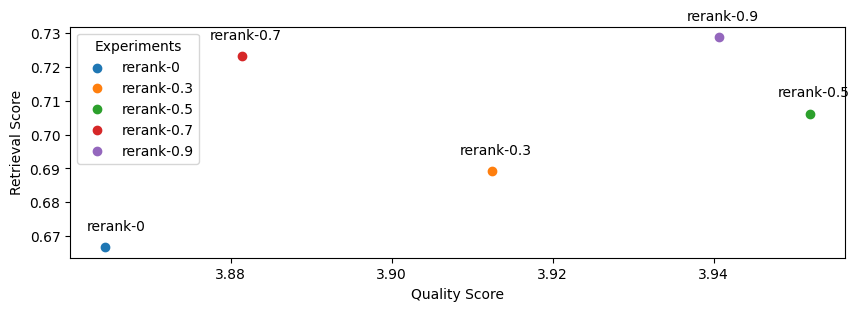

In [ ]:
scores = {}
for experiment_name in experiment_names:
    scores[experiment_name] = print_experiment(experiment_name, EXPERIMENTS_DIR)
plot_scores(scores=scores)

In [ ]:
original_num_chunks = NUM_CHUNKS
NUM_CHUNKS = 30
USE_RERANKING = True
RERANK_THRESHOLD = 0.5
RERANK_K = original_num_chunks + LEXICAL_SEARCH_K

**Note**: there is still a lot more to experiment with reranking (increasing the initial `num_chunks`, adding lexical search resutls *after* reranking, weighted reranking where we promote the top N classes, etc.)

In [ ]:
# Top experiments (by quality and retrieval score)
top_n = 3
experiment_results = {}
all_experiments = [d for d in Path(EXPERIMENTS_DIR, "evaluations").iterdir() if d.is_file()]
for experiment_fp in all_experiments:
    with open(str(experiment_fp), "r") as fp:
        results = json.load(fp)
    experiment_results[results["config"]["experiment_name"]] = {
        "retrieval_score": results["retrieval_score"], 
        "quality_score": results["quality_score"]}
sorted(experiment_results.items(), key=lambda i: (i[1].get("quality_score", float('inf')), i[1].get("retrieval_score")), reverse=True)[:top_n]

[('gpt-4-1106-preview',
  {'retrieval_score': 0.7288135593220338, 'quality_score': 4.209039548022599}),
 ('rerank-0.5',
  {'retrieval_score': 0.7062146892655368,
   'quality_score': 3.9519774011299433}),
 ('prompt-ignore-contexts',
  {'retrieval_score': 0.7344632768361582, 'quality_score': 3.943502824858757})]

# Cost analysis

Besides just performance, we also want to evaluate the cost of our configurations (especially given the high price points of larger LLMs). We’re going to break this down into prompt and sampled pricing. The prompt size is the number of characters in our system, assistant and user contents (which includes the retrieved contexts). And the sampled size is the number of characters the LLM generated in its response.

**Note**: Our OSS models are served via [Anyscale Endpoints](https://endpoints.anyscale.com/).

In [ ]:
from rag.config import PRICING

In [ ]:
def cost_analysis(experiment_name):
    eval_fp = Path(ROOT_DIR, EXPERIMENTS_DIR, "evaluations", f"{experiment_name}_{EVALUATOR}.json")
    with open(eval_fp, "r") as fp:
        d = json.load(fp)
    num_samples = len(d["results"])
    prompt_size, sampled_size = 0, 0
    for result in d["results"]:
        prompt_size += get_num_tokens(result["question"]) + \
            ((CHUNK_SIZE/5)*(4/3) * original_num_chunks)  # 5 chars / word, 1 token = 3/4 word
        sampled_size += get_num_tokens(result["generated_answer"])
    total_cost = PRICING[experiment_name]["prompt"]/1e6 * prompt_size + PRICING[experiment_name]["sampled"]/1e6 * sampled_size
    avg_cost = total_cost / num_samples
    
    print (experiment_name)
    print (f"  prompted tokens (avg): {int(prompt_size/num_samples)}")
    print (f"  sampled tokens (avg): {int(sampled_size/num_samples)}")
    print (f"  total cost: ${total_cost:.4f}")
    print (f"  avg cost: ${avg_cost:.4f}")
    print ()
    return avg_cost

In [ ]:
scores = {}
for experiment_name in PRICING.keys():
    scores[experiment_name] = print_experiment(experiment_name, EXPERIMENTS_DIR, verbose=False)
    scores[experiment_name]["average_cost"] = cost_analysis(experiment_name=experiment_name)

gpt-3.5-turbo
  prompted tokens (avg): 1695
  sampled tokens (avg): 73
  total cost: $0.4761
  avg cost: $0.0027

gpt-4
  prompted tokens (avg): 1695
  sampled tokens (avg): 111
  total cost: $10.1884
  avg cost: $0.0576

gpt-4-1106-preview
  prompted tokens (avg): 1695
  sampled tokens (avg): 200
  total cost: $4.0641
  avg cost: $0.0230

llama-2-7b-chat-hf
  prompted tokens (avg): 1695
  sampled tokens (avg): 248
  total cost: $0.0516
  avg cost: $0.0003

llama-2-13b-chat-hf
  prompted tokens (avg): 1695
  sampled tokens (avg): 226
  total cost: $0.0851
  avg cost: $0.0005

llama-2-70b-chat-hf
  prompted tokens (avg): 1695
  sampled tokens (avg): 218
  total cost: $0.3388
  avg cost: $0.0019

codellama-34b-instruct-hf
  prompted tokens (avg): 1695
  sampled tokens (avg): 187
  total cost: $0.3333
  avg cost: $0.0019

mistral-7b-instruct-v0.1
  prompted tokens (avg): 1695
  sampled tokens (avg): 135
  total cost: $0.0486
  avg cost: $0.0003

mixtral-8x7b-instruct-v0.1
  prompted token

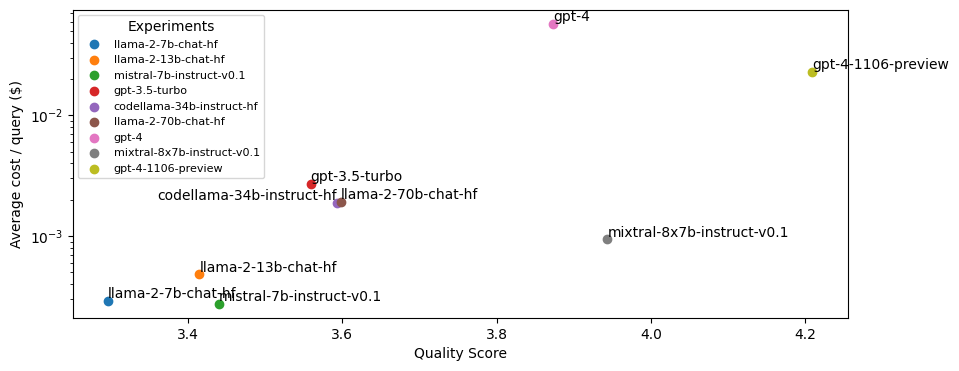

In [ ]:
# Prepare data for plotting
experiment_names = list(scores.keys())
average_costs = [scores[experiment_name]["average_cost"] for experiment_name in experiment_names]
quality_scores = [scores[experiment_name]["quality_score"] for experiment_name in experiment_names]
sorted_data = sorted(zip(quality_scores, average_costs, experiment_names))

# Plotting
plt.figure(figsize=(10, 4))
for i, (q_score, avg_cost, exp_name) in enumerate(sorted_data):
    plt.scatter(q_score, avg_cost, label=exp_name)
    ha = "left"  # Horizontal alignment
    va = "bottom"  # Vertical alignment
    offset = 0.02  # Small offset for labels
    if i > 0 and abs(sorted_data[i - 1][0] - q_score) < offset: ha = "left"  # Check left neighbor
    if i < len(sorted_data) - 1 and abs(sorted_data[i + 1][0] - q_score) < offset: ha = "right"  # Check right neighbor
    plt.text(q_score, avg_cost, exp_name, ha=ha, va=va, )

# Add labels and title
plt.xlabel("Quality Score")
plt.ylabel("Average cost / query ($)")
plt.legend(title="Experiments", loc="upper left", fontsize=8)
plt.yscale("log")
plt.show()

**Note**: This cost analysis is performed with our original experiments before lexical search, reranking, etc. since we haven't run experiments with these improvements on the other OSS and closed source LLMs yet.

# Routing

It seems that the most performant LLM, `gpt-4-turbo`, is also very expensive. While our OSS LLM (`mixtral-8x7b-instruct-v0.1`) is very close in quality but ~25X more cost-effective.

In [ ]:
# Cost multiplier
chosen_model = LLM.split('/')[-1].lower()
print (f"Cost multiplier compared to {chosen_model}")
for model in scores:
    print (f"  {model}: {scores[model]['average_cost']/scores[chosen_model]['average_cost']:.2f}X")

Cost multiplier compared to mixtral-8x7b-instruct-v0.1
  gpt-3.5-turbo: 2.87X
  gpt-4: 61.35X
  gpt-4-1106-preview: 24.47X
  llama-2-7b-chat-hf: 0.31X
  llama-2-13b-chat-hf: 0.51X
  llama-2-70b-chat-hf: 2.04X
  codellama-34b-instruct-hf: 2.01X
  mistral-7b-instruct-v0.1: 0.29X
  mixtral-8x7b-instruct-v0.1: 1.00X


However, we want to be able to serve the most performant and cost-effective solution. We can close this gap in performance between open source and proprietary models by routing queries to the right model according to the complexity or topic of the query. For example, in our application, open source models perform really well on simple queries where the answer can be easily inferred from the retrieved context. However, the OSS models fall short for queries that involve reasoning, numbers or code examples. To identify the appropriate LLM to use, we can train a classifier that takes the query and routes it to the best model.

<img width="800" src="https://images.ctfassets.net/xjan103pcp94/7FWrvPPlIdz5fs8wQgxLFz/fdae368044275028f0544a3d252fcfe4/image15.png">

**Note**: In part 2 of this series, we’ll fine-tune our embedding models and OSS LLMs to make them even more performant.

In order to implement this, we hand-annotated a [dataset of 1.8k queries](https://github.com/ray-project/llm-applications/blob/main/datasets/routing-dataset-train.jsonl) according to which model (`gpt-4` (label=0) or `codellama-34b` (label=1)) would be appropriate -- by default we route to OSS LLM and only if the query needs more advanced capabilities do we send the query to `gpt-4`. We then evaluate the performance of the model on a test set that has been scored with an evaluator.

## Dataset

Let's first train the model on the training dataset [routing-dataset-training.jsonl](https://github.com/ray-project/llm-applications/blob/main/datasets/routing-dataset-train.jsonl):

In [ ]:
with open(Path(ROOT_DIR, "datasets", "routing-dataset-train.jsonl")) as f:
    records = [json.loads(l) for l in f]
    texts = [record["question"] for record in records]
    labels = [record["target"] for record in records]

In [ ]:
# Sample records (1 = can be handled by OSS LLM)
print ("Question for gpt-4:\n", [record for record in records if record["target"] == 0][0]) 
print ("\nQuestion for OSS LLM:\n", [record for record in records if record["target"] == 1][0])

Question for gpt-4:
 {'question': 'if I am inside of a anyscale cluster how do I get my cluster-env-build-id', 'target': 0}

Question for codellama-34b:
 {'question': 'what is num_samples in tune?', 'target': 1}


## Modeling

In [ ]:
import pickle
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

In [ ]:
# Train classifier
router = Pipeline([
    ("vectorizer", CountVectorizer()),
    ("classifier", LogisticRegression(multi_class="multinomial", solver="lbfgs"))
])
router.fit(texts, labels)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', LogisticRegression(multi_class='multinomial'))])

**Note**: we also trained a BERT classifier and performance was not as good as our logistic regression use case given the size of our dataset.

## Inference

In [ ]:
# Router file path
router_fp = Path(EFS_DIR, "router.pkl")

In [ ]:
# Save
with open(router_fp, "wb") as file:
    pickle.dump(router, file)

In [ ]:
# Load
with open(router_fp, "rb") as file:
    router = pickle.load(file)

In [ ]:
# Inference
router_map = {0: "GPT-4", 1: "OSS"}
query = "What is the default batch size for map_batches?"
print (f"[{router_map[router.predict([query])[0]]}]", query)

[OSS] What is the default batch size for map_batches?


## Evaluation

Now let's evaluate the performance on the [test dataset](https://github.com/ray-project/llm-applications/blob/main/datasets/routing-dataset-test.jsonl):

In [ ]:
import numpy as np
import pickle
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
# Load
with open(router_fp, "rb") as file:
    router = pickle.load(file)

In [ ]:
with open(Path(ROOT_DIR, "datasets", "routing-dataset-test.jsonl")) as f:
    records = [json.loads(line) for line in f]
    texts = [record["question"] for record in records]
    y_test = [record["target"] for record in records]
    score_test = [record["score"] for record in records]

In [ ]:
# Predictions
y_pred = router.predict(texts)

In [ ]:
metrics = {}
performance = precision_recall_fscore_support(y_test, y_pred, average="weighted")
metrics["precision"] = performance[0]
metrics["recall"] = performance[1]
metrics["f1"] = performance[2]
metrics["num_samples"] = np.float64(len(y_test))
print (json.dumps(metrics, indent=4))

{
    "precision": 0.9191264005602239,
    "recall": 0.9285714285714286,
    "f1": 0.9226432439812495,
    "num_samples": 574.0
}


In [ ]:
print ("# total samples", len(y_pred))
print(f"# samples for OSS models: {sum(y_pred)} ({sum(y_pred)*100/len(y_pred):.1f}%)")
print(f"Performance on samples predicted for {LLM}: {np.mean([score_test[i] for i, p in enumerate(y_pred) if p]):.2f}")
print(f"Performance on samples predicted for gpt-4: {np.mean([score_test[i] for i, p in enumerate(y_pred) if not p]):.2f}")

# total samples 574
# samples for OSS models: 544 (94.8%)
Performance on samples predicted for codellama/CodeLlama-34b-Instruct-hf: 3.87
Performance on samples predicted for gpt-4: 3.55


**Note**: For our dataset, a small logistic regression model is good enough to perform the routing. But if your use case is more complex, consider training a more complex model, like a BERT-based classifier to perform the classification. These models are still small enough that wouldn’t introduce too much latency. Be sure to check out this [guide](https://github.com/GokuMohandas/Made-With-ML) if you want to learn how to train and deploy supervised deep learning models.

# Serving

Now we're ready to start serving our Ray Assistant using our best configuration. We're going to use [Ray Serve](https://docs.ray.io/en/latest/serve/index.html) with [FastAPI](https://fastapi.tiangolo.com/) to develop and scale our service. First, we'll define some data structures like `Query` and `Answer` to represent the inputs and outputs to our service. We will also define a small function to load our index (assumes that the respective SQL dump file already exists). Finally, we can define our `QueryAgent` and use it to serve `POST` requests with the query. And we can serve our agent at any deployment scale we wish using the [@serve.deployment](https://docs.ray.io/en/latest/serve/api/doc/ray.serve.Deployment.html) decorator where we can specify the number of replicas, compute resources, etc.

In [ ]:
import pickle
import requests
from typing import List

In [ ]:
from fastapi import FastAPI
from pydantic import BaseModel
from ray import serve
from rag.generate import QueryAgent
from rag.index import build_or_load_index

In [ ]:
# Initialize application
app = FastAPI()

In [ ]:
class Query(BaseModel):
    query: str

In [ ]:
class Answer(BaseModel):
    question: str
    sources: List[str]
    answer: str
    llm: str

In [ ]:
@serve.deployment(route_prefix="/", num_replicas=1, ray_actor_options={"num_cpus": 6, "num_gpus": 1})
@serve.ingress(app)
class RayAssistantDeployment:
    def __init__(self, chunk_size, chunk_overlap, num_chunks, 
                 embedding_model_name, embedding_dim,
                 use_lexical_search, lexical_search_k, 
                 use_reranking, rerank_threshold, rerank_k,
                 llm, sql_dump_fp=None):
        
        # Set up
        chunks = build_or_load_index(
            embedding_model_name=embedding_model_name, 
            embedding_dim=embedding_dim, 
            chunk_size=chunk_size, 
            chunk_overlap=chunk_overlap,
            sql_dump_fp=sql_dump_fp,
        )

        # Lexical index
        lexical_index = None
        self.lexical_search_k = lexical_search_k
        if use_lexical_search:
            texts = [re.sub(r"[^a-zA-Z0-9]", " ", chunk[1]).lower().split() for chunk in chunks]
            lexical_index = BM25Okapi(texts)

        # Reranker
        reranker = None
        self.rerank_threshold = rerank_threshold
        self.rerank_k = rerank_k
        if use_reranking:
            reranker_fp = Path(EFS_DIR, "reranker.pkl")
            with open(reranker_fp, "rb") as file:
                reranker = pickle.load(file)

        # Query agent
        self.num_chunks = num_chunks
        system_content = "Answer the query using the context provided. Be succinct. " \
            "Contexts are organized in a list of dictionaries [{'text': <context>}, {'text': <context>}, ...]. " \
            "Feel free to ignore any contexts in the list that don't seem relevant to the query. "
        self.oss_agent = QueryAgent(
            embedding_model_name=embedding_model_name,
            chunks=chunks,
            lexical_index=lexical_index,
            reranker=reranker,
            llm=llm,
            max_context_length=MAX_CONTEXT_LENGTHS[llm],
            system_content=system_content)
        self.gpt_agent = QueryAgent(
            embedding_model_name=embedding_model_name,
            chunks=chunks,
            lexical_index=lexical_index,
            reranker=reranker,
            llm="gpt-4",
            max_context_length=MAX_CONTEXT_LENGTHS["gpt-4"],
            system_content=system_content)

        # Router
        router_fp = Path(EFS_DIR, "router.pkl")
        with open(router_fp, "rb") as file:
            self.router = pickle.load(file)

    @app.post("/query")
    def query(self, query: Query) -> Answer:
        use_oss_agent = self.router.predict([query.query])[0]
        agent = self.oss_agent if use_oss_agent else self.gpt_agent
        result = agent(
            query=query.query, num_chunks=self.num_chunks, 
            lexical_search_k=self.lexical_search_k, 
            rerank_threshold=self.rerank_threshold, 
            rerank_k=self.rerank_k, 
            stream=False)
        return Answer.parse_obj(result)

**Note**: As we can see, Ray Serve makes [model composition](https://docs.ray.io/en/latest/serve/model_composition.html) extremely easy and we could continue to make this more fine-grained. For example, we can train a classifier to discern between queries for `mixtral-8x7b-instruct-v0.1`,` codellama-34b-instruct-hf` (for code generation) and `gpt-4` (for highly complex queries). Also, we can use streaming end-to-end to reduce the time a user has to wait for the answer. Check out the `/stream` method in `rag/serve.py`.

In [ ]:
# Deploy the Ray Serve application.
deployment = RayAssistantDeployment.bind(
    chunk_size=CHUNK_SIZE,
    chunk_overlap=CHUNK_OVERLAP,
    num_chunks=NUM_CHUNKS,
    embedding_model_name=EMBEDDING_MODEL_NAME,
    embedding_dim=EMBEDDING_DIMENSIONS[EMBEDDING_MODEL_NAME],
    use_lexical_search=USE_LEXICAL_SEARCH,
    lexical_search_k=LEXICAL_SEARCH_K, 
    use_reranking=USE_RERANKING, 
    rerank_threshold=RERANK_THRESHOLD, 
    rerank_k=RERANK_K,
    llm=LLM,
    sql_dump_fp=SQL_DUMP_FP)
serve.run(deployment)

(ServeController pid=213991) WARNING 2023-11-09 22:10:03,839 controller 213991 application_state.py:663 - The deployments ['RayAssistantDeployment'] are UNHEALTHY.
(ServeController pid=213991) INFO 2023-11-09 22:10:03,942 controller 213991 deployment_state.py:1390 - Deploying new version of deployment RayAssistantDeployment in application 'default'.
(ServeController pid=213991) INFO 2023-11-09 22:10:04,044 controller 213991 deployment_state.py:1679 - Adding 1 replica to deployment RayAssistantDeployment in application 'default'.
(ServeReplica:default:RayAssistantDeployment pid=217138) Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
(ServeReplica:default:RayAssistantDeployment pid=217138) Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
(ServeReplica:default:RayAssistantDeployment pid=217138) INFO 2023-11-09 22:10:27,795 RayAssistantDeployment defaul

RayServeSyncHandle(deployment='RayAssistantDeployment')

In [ ]:
# Inference
data = {"query": "What is the default batch size for map_batches?"}
response = requests.post("http://127.0.0.1:8000/query", json=data)
response.json()

{'question': 'What is the default batch size for map_batches?',
 'sources': ['https://docs.ray.io/en/master/data/batch_inference.html#configuring-batch-size',
  'https://docs.ray.io/en/master/data/transforming-data.html#configuring-batch-size',
  'https://docs.ray.io/en/master/data/examples/pytorch_resnet_batch_prediction.html#model-inference',
  'https://docs.ray.io/en/master/data/api/doc/ray.data.Dataset.map_batches.html#ray-data-dataset-map-batches',
  'https://docs.ray.io/en/master/data/batch_inference.html#configuring-batch-size',
  'https://docs.ray.io/en/master/data/examples/huggingface_vit_batch_prediction.html#step-3-scaling-up-to-the-full-dataset-with-ray-data',
  'https://docs.ray.io/en/master/serve/advanced-guides/dyn-req-batch.html#tips-for-fine-tuning-batching-parameters',
  'https://docs.ray.io/en/master/data/api/doc/ray.data.Dataset.map_batches.html#ray-data-dataset-map-batches',
  'https://docs.ray.io/en/master/data/examples/batch_inference_object_detection.html#model-

(ServeReplica:default:RayAssistantDeployment pid=217138) INFO 2023-11-09 22:10:35,329 RayAssistantDeployment default#RayAssistantDeployment#ZuxuxM 380d5b6f-c3f8-43fa-a3c9-c22d5b04b47d /query default replica.py:749 - __CALL__ OK 3430.1ms


**Note**: As we can see, Ray Serve makes [model composition](https://docs.ray.io/en/latest/serve/model_composition.html) extremely easy and we could continue to make this even more fine-grained with more workflow logic.

Once our application is served, we’re free to use it anywhere we want. For example, we use it as a bot on our Slack channels and as a widget on our docs page (public release coming soon). We can use this to collect feedback from our users to continually improve the application (fine-tuning, UI/UX, etc.).

<img width="600" src="https://images.ctfassets.net/xjan103pcp94/7pyW8T7La5T51C8iXEwmAO/706dc8ed0ca75cdcbf971d9e74cd67b3/Screenshot_2023-10-24_at_12.56.39_PM.png">

In [ ]:
# Shutdown
serve.shutdown()

2023-11-09 22:10:41,238	INFO router.py:473 -- Got updated replicas for deployment 'RayAssistantDeployment' in application 'default': set().
(ServeController pid=213991) INFO 2023-11-09 22:10:41,235 controller 213991 deployment_state.py:1707 - Removing 1 replica from deployment 'RayAssistantDeployment' in application 'default'.
(ServeController pid=213991) INFO 2023-11-09 22:10:43,848 controller 213991 deployment_state.py:2027 - Replica default#RayAssistantDeployment#ZuxuxM is stopped.


# Data flywheel

Creating an application like this is not a one-time task. It's extremely important that we continue to iterate and keep our application up to date. This includes continually reindexing our data so that our application is working with the most up-to-date information. As well as rerunning our experiments to see if any of the decisions need to be altered. This process of continuous iteration can be achieved by mapping our workflows to [CI/CD pipelines](https://madewithml.com/courses/mlops/cicd/).

A key part of iteration that goes beyond automated reindexing, evaluation, etc. involves fixing our data itself. In fact, we found that this is the **most** impactful lever (way beyond our retrieval and generation optimizations above) we could control. Here is an example workflow we've settled on:
1. Users use the RAG application to ask questions about the product.
2. Use feedback (👍/👎, visited source pages, top-k cosine scores, etc.) to identify underperforming queries.
3. Inspect the retrieved resources, tokenization, etc. to decide if it's a shortcoming of retrieval, generation or the underlying data source.
4. If something in the data can be improved, separated into sections/pages, etc. → fix it!
5. Reindex and deploy a new version of the application.

# Impact

## Products and productivity

Building an LLM application like this has had a tremendous impact on our products and company. There were expected 1st order impacts in overall developer and user adoption for our products. The capability to interact and solve problems that our users experience in a self-serve and immediate manner is the type of feature that would improve the experience of any product. It makes it significantly easier for people to succeed and it elevated the perception around LLM applications from a **nice-to-have** to a **must-have**. 

## Foundational agents

However, there were also some 2nd order impacts that we didn’t immediately realize. For example, when we further inspected user queries that yielded poor scores, often the issue existed because of a gap in our documentation. When we made the fix (ex. added the appropriate section to our docs), this improved our product and the LLM application itself — creating a very valuable feedback flywheel. Furthermore, when internal teams learned of the capabilities of our LLM application, this generated the development of highly valuable LLM applications that depend on this Ray docs LLM application as one of its **foundational agents** that it uses to perform its tasks.

<img width="700" src="https://images.ctfassets.net/xjan103pcp94/2UF2tSV3kmXtrzmqMsYrLF/76bcc71b481986eb6cb3b06d60582ec5/image18.png">

For example, we’ve internally developed a feature called Anyscale Doctor that helps developers diagnose and debug issues during development. Issues in code can be caused by a variety of reasons but when the issue is Ray related, the LLM application we built here is called to aid in resolving the particular issue.

# Learn more

- If your team is investing heavily in developing LLM applications, [reach out](mailto:endpoints-help@anyscale.com) to us to learn more about how [Ray](https://github.com/ray-project/ray) and [Anyscale](http://anyscale.com/) can help you scale and productionize everything.
- Start serving (+fine-tuning) OSS LLMs with [Anyscale Endpoints](https://www.anyscale.com/endpoints) ($1/M tokens for Llama-2-70b) w/ 1M free tokens trial.
- If you need to deploy on your own private cloud, check out [Anyscale Private Endpoints](https://www.anyscale.com/endpoints#private).
- Learn more about how companies like OpenAI, Netflix, Pinterest, Verizon, Instacart and others leverage Ray and Anyscale for their AI workloads at the [Ray Summit](https://raysummit.anyscale.com/).
